# DE data analysis

I still feel the need to have a notebook storing all the data analysis. It has the following components:

**Main content**

- [the parameter space of $OD$, $D$, $d$](#0-Parameter-space)
- [trajectory visualization and position distribution](#1-Trajectory-visualization-and-position-distributions)
- [MSD of all curves](#2-All-MSD-curves)
- [extraction of $D_A$, $\tau$ and $\tau^*$ from MSD (fitting)](#3-Fit-MSD-curves)
- [$D_A$, $\tau$ and $\tau^*$ depends on $D$, $d$ and $OD$](#4-Geometry-and-concentration-dependence)

**Appendix**

- [small displacement approximation validation](#A.-Small-displacement-approximation-validation)
- [influence of velocity](#B.-Influence-of-mean-velocity)
- [influence of total bacteria number](#C.-Total-number-of-bacteria-in-a-droplet)

<font color="blue">
    
## Plans

- An intuitive **limit case** to test is $D\to \infty$. Practically, we can study the diffusion of oil droplets near a flat glass surface, agitated by active bacterial bath. Such unconfined motion will likely give a superdiffusive-diffusive type of MSD, and can be fitted using Wu and Libchaber's model for a diffusivity $D_A$. Such $D_A$, according to the current trend, should be the upper bound of the corresponding $D_A$'s confined in curved spaces. An experiment of oil droplets near a flat glass surface is needed!

</font>

In [46]:
from deLib import de_data
import pandas as pd
import os
import matplotlib.pyplot as plt
from myImageLib import bestcolor, gauss1, readdata
import numpy as np
from scipy.optimize import curve_fit
import trackpy as tp
from matplotlib.patches import Ellipse, Circle
from corrLib import autocorr1d
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d
from matplotlib import colors, cm

## 0 Parameter space

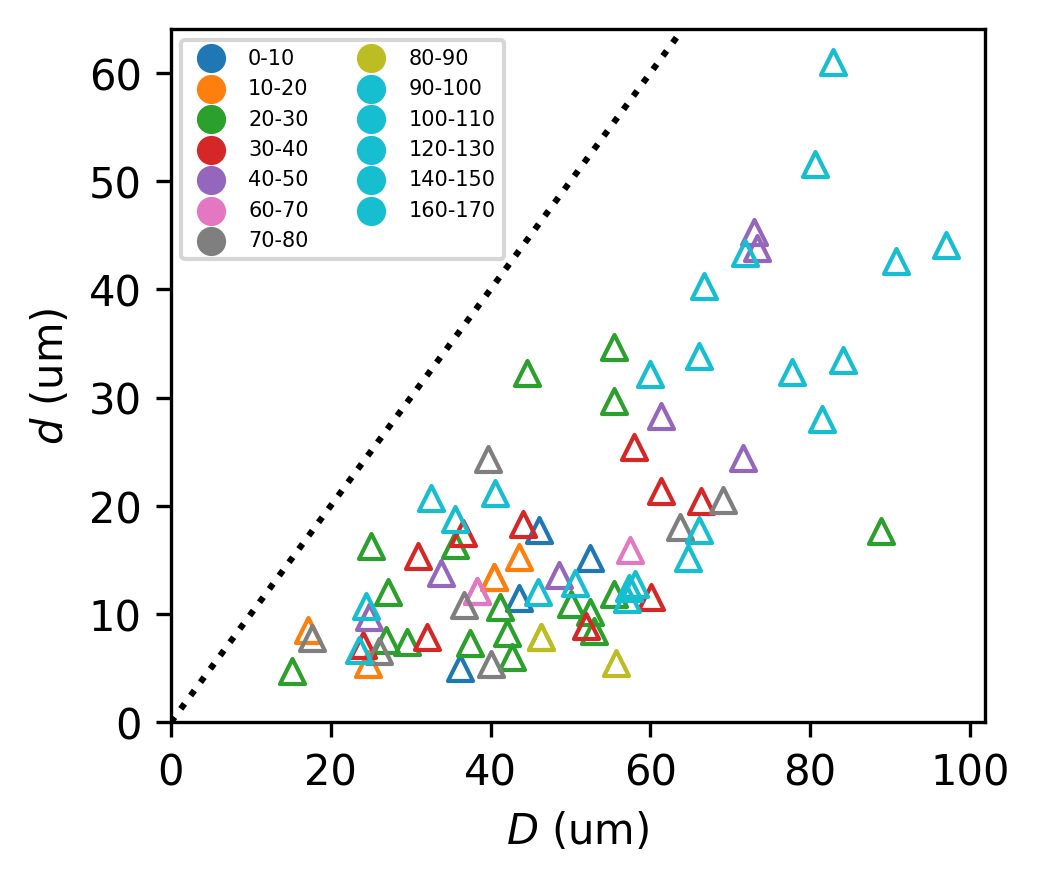

In [47]:
# load log file
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods")).set_index("DE#")

# filter out Chile data
log1 = log.loc[(log.Comment=="Chile")]
dd = de_data(log1)

dd.parameter_space()
# plt.scatter(log_new.D, log_new.d, marker="^", edgecolor=bestcolor(1), facecolor=(0,0,0,0))

## 1 Trajectory visualization and position distributions

### 1.1 Plot trajectory, PDF and autocorrelation

In [24]:
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
n = 175
traj = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(n))
# traj = trajo.fillna(method="bfill")
log_item = log.loc[log["DE#"]==n]
MPP = float(log_item.MPP)
FPS = float(log_item.FPS)
print("number of nan: {:d}".format(len(traj.loc[np.isnan(traj.y)])))
# print("after bfill: {:d}".format(len(traj.loc[np.isnan(traj.y)])))

number of nan: 20


In [5]:
traj = traj.dropna()

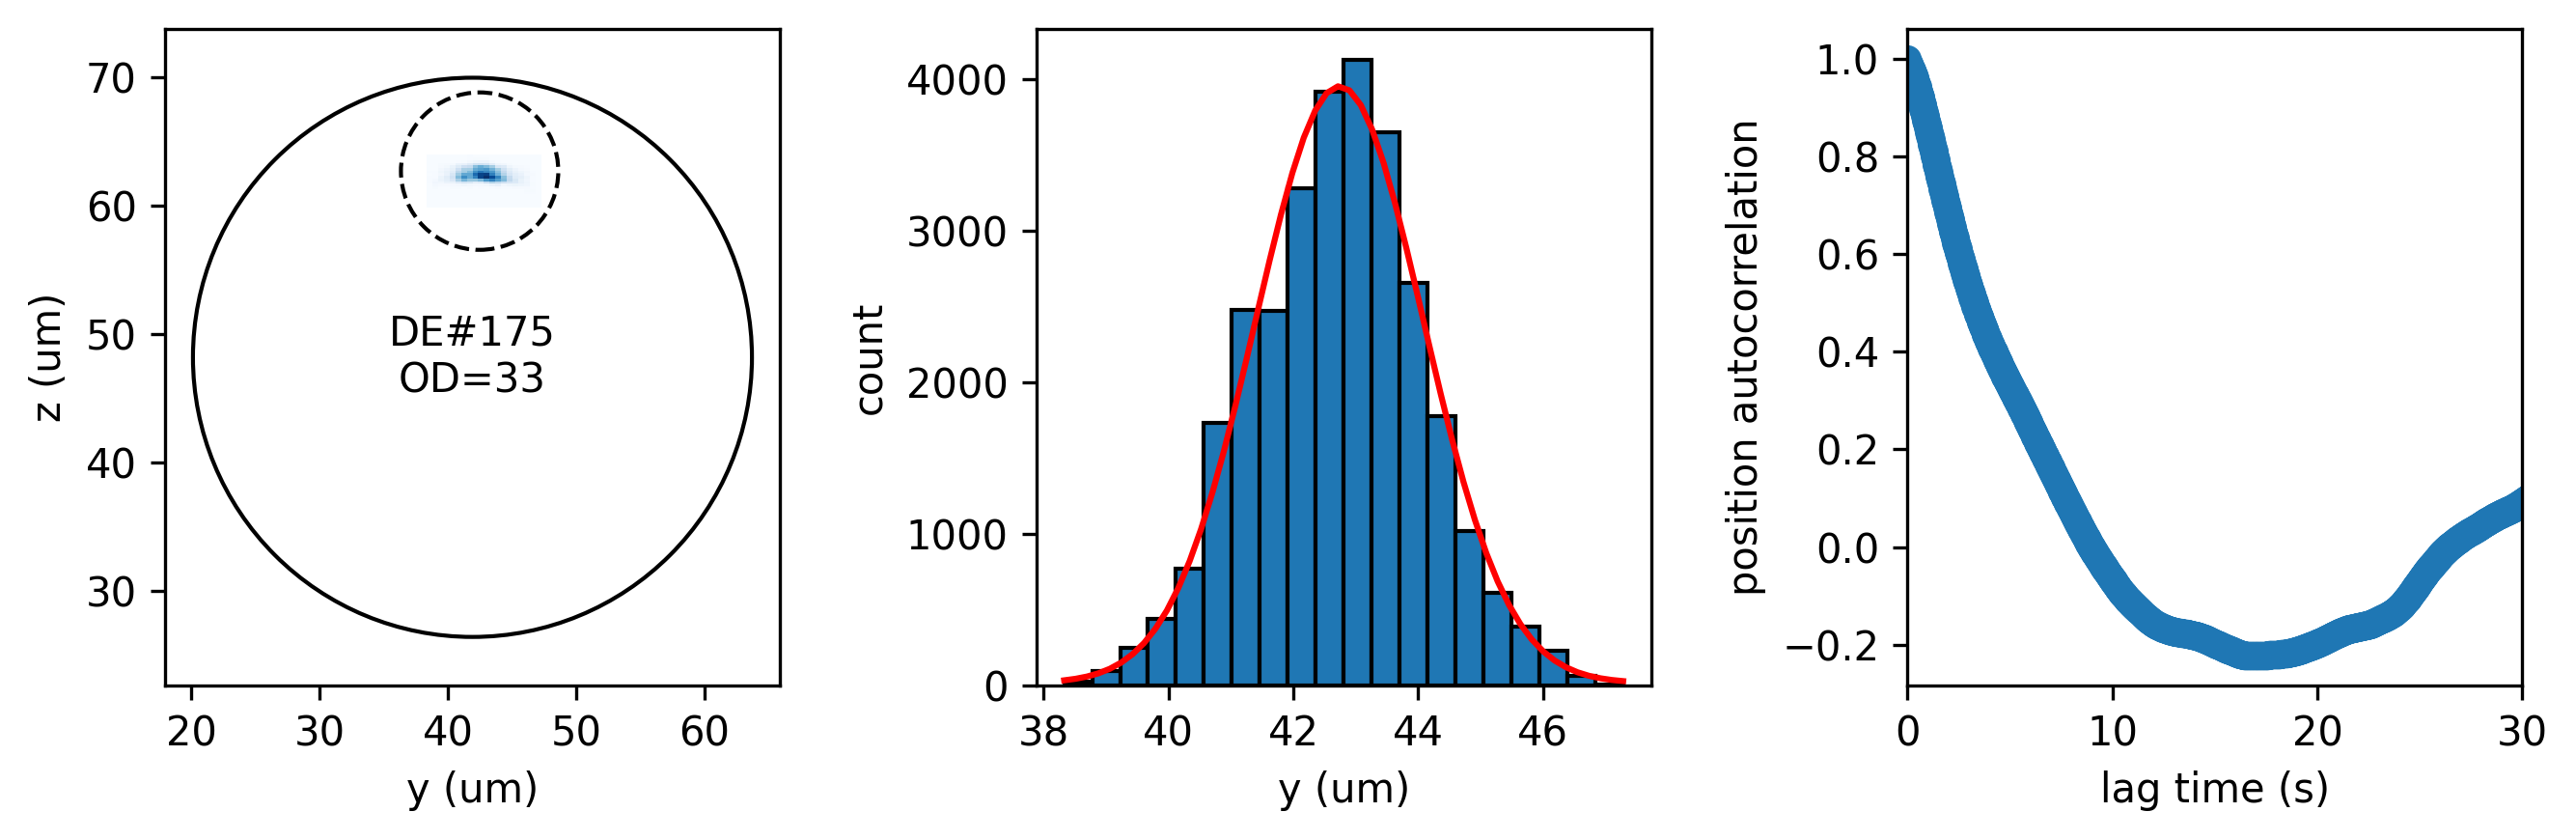

In [6]:
fig = plt.figure(figsize=(9, 3), dpi=300)
ax = fig.add_subplot(131)
# ax.scatter(traj.y*MPP, traj.x*MPP, alpha=0.5)
ax.hist2d(traj.y*MPP, traj.x*MPP, bins=(20, 20), cmap="Blues")
elli = Circle(((log_item.y0*log_item.MPP).iloc[0], log_item.x0.iloc[0]*MPP), log_item.D.iloc[0]/2, fill=False, color="black")
elli_inner = Circle((traj.y.dropna().iloc[0]*MPP, traj.x.dropna().iloc[0]*MPP), log_item.d.iloc[0]/2, fill=False, color="black", ls="--")
ax.add_patch(elli)
ax.add_patch(elli_inner)
ax.axis("equal")
ax.set_xlabel("y (um)")
ax.set_ylabel("z (um)")

ax.annotate("DE#{0:02d}\nOD={1:d}".format(n, int(log_item.OD)), (log_item.y0*log_item.MPP, log_item.x0*MPP), 
            horizontalalignment="center", verticalalignment="center")

# Position probability distribution
hist, bin_edges = np.histogram(traj.y.dropna()*MPP, bins=20)
ax2 = fig.add_subplot(132, sketch_params={"scale": 1, "length": 10, "randomness": 1})
ax2.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax2.set_ylabel("count")
ax2.set_xlabel("y (um)")

## Fit a Gaussian to the position distribution
x = np.linspace(bin_edges[0], bin_edges[-1])
popt, pcov = curve_fit(gauss1, (bin_edges[:-1]+bin_edges[1:])/2, hist, 
                       p0=[hist.mean(), bin_edges.mean(), bin_edges[-1]-bin_edges[0], 0])
ax2.plot(x, gauss1(x, *popt), color="red")

# Position autocorrelation
corr, lagt = autocorr1d(traj.y, traj.frame/FPS)#.fillna(method="ffill").fillna(method="bfill"))
lagt = 1 / FPS * traj.frame[:len(corr)]
ax3 = fig.add_subplot(133)
ax3.scatter(lagt, corr)
ax3.set_xlabel("lag time (s)")
ax3.set_ylabel("position autocorrelation")
ax3.set_xlim([0, 30])

plt.tight_layout()

# print("corr_time = {:.1f}".format(lagt[find_zero(corr-1e-1)]))
# print("sigma = {:.1f}".format(abs(popt[2])))


### 1.2 Autocorrelation of time series with missing values

With missing values, my function `autocorr1d()` returns an array full of nan. It is very tedious to fill all the missing data. Therefore, we seek a method to compute autocorrelation with the presence of missing data. 

#### 1.2.1 Find the longest consecutive time series

In [241]:
# load traj
n = 175
trajo = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(n))
# link traj using memory=0, this will assign particle numbers to consecutive trajs
t1 = tp.link(trajo, 50, memory=0)
# remove missing value rows
t1 = t1.dropna()

Frame 29026: 1 trajectories present.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



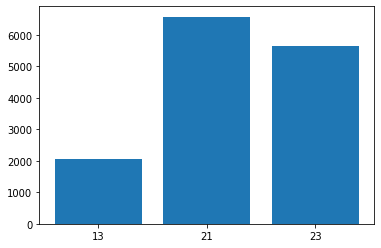

In [250]:
# particle number histogram
length_thres = 2000
count_list = []
p_list = []
for _, g in t1.groupby("particle"):
    if len(g) > length_thres:
        p_list.append(str(g.particle.iloc[0]))
        count_list.append(len(g))
if len(p_list) > 0:
    plt.bar(p_list, count_list)
    a = plt.xticks(p_list)
else: 
    print("No consecutive trajectory longer than {:d} frame is found.".format(length_thres))

Text(0, 0.5, 'autocorrelation')

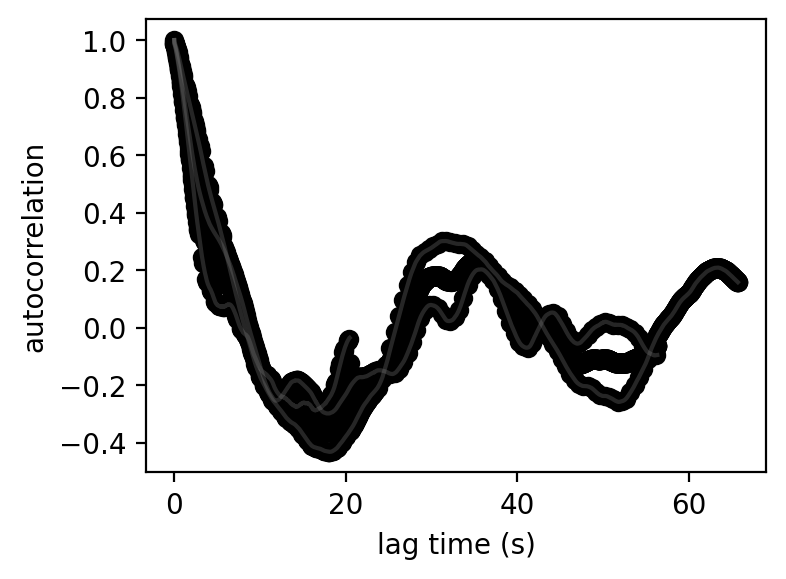

In [251]:
# Use all the long trajs to measure autocorr
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
df_list = []
for p in p_list:
    p = int(p)
    t2 = t1.loc[t1.particle==p]
    corr, lagt = autocorr1d(t2.y, np.array(t2.frame)/FPS)
    df = pd.DataFrame({"corr": corr}, index=lagt)
    df_list.append(df)
    ax.plot(lagt, corr, color="gray", alpha=0.3)
combine = pd.concat(df_list, axis=1)
ax.scatter(combine.index, combine.mean(axis=1), color="black")
ax.set_xlabel("lag time (s)")
ax.set_ylabel("autocorrelation")

This method works for some data, where there are long enough consecutive trajectories in the original data (e.g. DE#175). However, for those who has many short segments of trajectories, this method does not make full use of the data (e.g. DE#176). 

#### 1.2.2 Rewrite the autocorr1d to handle time series with missing values

With missing data, it's impossible to use `np.correlate()` function, which is fast. Instead, by definition, we can implement a _for_ loop to compute the autocorrelation at a slower speed.  

In [7]:
# artificial time series with/without nan
x = np.random.rand(100)
t = np.arange(len(x))/50
xm = x.copy()
xm[10] = np.nan

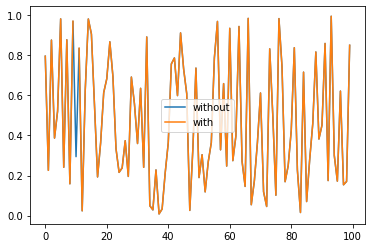

In [9]:
# visualize
plt.plot(x, label="without")
plt.plot(xm, label="with")
plt.legend()

Text(0, 0.5, 'autocorrelation')

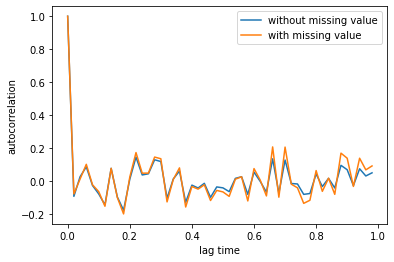

In [10]:
# show the equivalence of two methods
corr, lagt = autocorr1d(x, t)
plt.plot(lagt, corr, label="without missing value")
corr, lagt = autocorr1d(xm, t)
plt.plot(lagt, corr, label="with missing value")
plt.legend()
plt.xlabel("lag time")
plt.ylabel("autocorrelation")

<font color="blue"> In general, the second approach is more robust, since it does not require long enough sub-series. However, it can be very slow for long time series. I rewrite the `autocorr1d()` function in `corrLib` to handle missing values.</font>

### 1.3 Pendulum-like motion in concentrated bacterial suspensions

We notice that the motion of droplets in bacterial suspension gets less of noisy at the onset of collective motion. Instead, it looks like there is an effective inertia in the system pushing the inner droplets. To convert this "feeling" to "numbers", we quantify these motions in various way, and compare with theory. 

At high bacterial concentration, collective motion takes place. The inner droplet agitated by collectively moving bacteria exhibits a pendulum-like motion, which is qualitatively different from a noise-driven motion. Such pendulum-like motion is characterized by **high probability of finding the droplet at high potential positions**, as well as a **non-diffusive position autocorrelation**. Here, we analyze these two properties of the inner droplet trajectories and see if the two characteristics mentioned above really exists in our system. 

### 1.3.1 Hypothesis: constant speed circular motion
![](../images/2022/06/circular-motion.png)
$$
x = r\cos\omega t\\
y = r\sin\omega t\\
$$

If we look at the $y$-projection of the trajectory in one period:

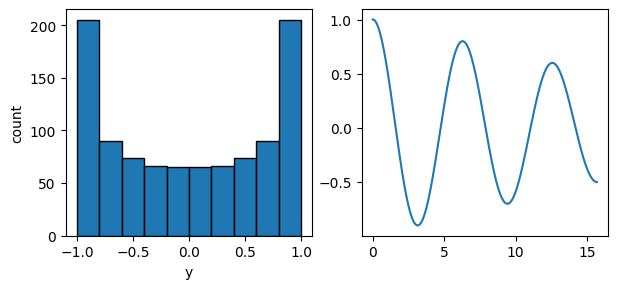

In [12]:
# artificial circular motion
w = 1
r = 1
t = np.linspace(0, 10*np.pi/w, 1000)
y = r * np.sin(w*t)

hist, bin_edges = np.histogram(y)
fig= plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(121)
ax.bar((bin_edges[:-1]+bin_edges[1:])/2, hist, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax.set_xlabel("y")
ax.set_ylabel("count")

ax2 = fig.add_subplot(122)
corr, lagt = autocorr1d(y, t)
ax2.plot(lagt, corr)

This circular motion has a very extreme bimodal position distribution. Actually, we saw this circular motion in the $xy$-plane very early on in experiment, and I made the best 3-D trajectory visualization out of that experiment. 

![rvref](../images/outer-ref-demo.gif)

The corresponding position distribution:

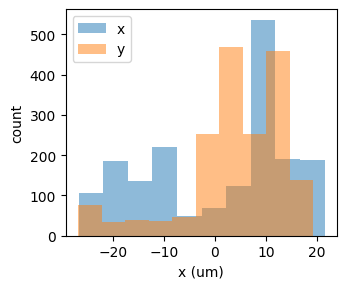

In [13]:
traj = pd.read_csv(r"..\Data\traj\01.csv")
MPP = 0.1
xhist, xbin_edges = np.histogram((traj.x-518)*MPP)
yhist, ybin_edges = np.histogram((traj.y-514)*MPP)

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
ax.bar((xbin_edges[:-1]+xbin_edges[1:])/2, xhist, width=xbin_edges[1]-xbin_edges[0],  alpha=0.5, label="x")
ax.bar((ybin_edges[:-1]+ybin_edges[1:])/2, yhist, width=ybin_edges[1]-ybin_edges[0],  alpha=0.5, label="y")
ax.set_xlabel("x (um)")
ax.set_ylabel("count")
ax.legend()

## 2 All MSD curves

In [7]:
# There are trajectories that show weird MSD, 
# some of them are due to the very tiny displacement, 
# for others the reason is not yet clear
suspicious_traj = [161, 171, 172, 176, 179, 182, 185, 192, 194, 55]

In [11]:
log1

,Date,Video#,MPP,FPS,OD,D,D_err,d,d_err,Easy to analyze?,...,t1_fit,t2_fit,DA_fit,(D-d)/d,DA/OD,c,number of bacteria,mean velocity (1s),mean velocity middle,mean velocity end
DE#,,,,,,,,,,,,,,,,,,,,,
23,2021-10-26,11,0.11,50.0,65,48.90000,NaN,17.00000,NaN,Yes,...,NaN,2.424754,2.128236,1.876471,0.032742,0.400820,3048.360559,1.925,NaN,NaN
24,2021-10-26,12,0.11,50.0,65,74.00000,NaN,15.40000,NaN,Yes,...,NaN,3.620000,24.340000,3.805195,0.374462,0.888277,10928.105509,1.716,NaN,NaN
25,2021-10-26,13,0.11,50.0,65,63.40000,NaN,30.90000,NaN,Yes,...,NaN,1.664580,1.281568,1.051780,0.019716,0.259675,6132.156606,0.847,NaN,NaN
35,2021-11-02,1,0.11,50.0,42,47.00000,NaN,9.50000,NaN,NaN,...,NaN,8.868898,1.914747,3.947368,0.045589,0.631025,1810.547550,1.180,1.13,0.96
37,2021-11-02,3,0.11,50.0,42,93.60000,NaN,26.90000,NaN,NaN,...,NaN,2.106748,2.108728,2.479554,0.050208,0.186872,14077.060175,1.030,0.99,0.96
38,2021-11-02,5,0.33,50.0,51,140.00000,NaN,20.00000,NaN,NaN,...,NaN,2.135075,8.412466,6.000000,0.164950,0.212199,58419.072000,3.090,2.69,2.40
39,2021-11-02,8,0.11,50.0,41,110.00000,NaN,20.00000,NaN,NaN,...,NaN,2.072361,18.376247,4.500000,0.448201,0.400000,22709.736000,1.010,1.08,0.98
40,2021-11-02,9,0.11,47.8,41,109.40000,NaN,23.20000,NaN,NaN,...,NaN,1.589618,15.152995,3.715517,0.369585,0.333796,22260.886839,0.970,1.03,0.94
41,2021-11-02,13,0.65,50.0,61,201.20000,NaN,51.40000,NaN,Yes,...,NaN,2.633309,5.986761,2.914397,0.098144,0.159872,204540.943093,2.250,3.96,2.76


### 2.1 Compute MSD from trajectories

In the repo, we only save the trajectories, as they are considered as the raw data from the videos. In constrast, MSD is a derivative of trajectory, and is different if trajectories are modified. Therefore, we compute MSD every time from the saved trajectories.

In [59]:
# load all the trajectories and compute corresponding MSDs
traj_list, msd_list = {}, {}
for num, i in log1.iterrows():
    nDE = int(num)
    traj_list[nDE] = pd.read_csv(r"..\Data\traj\{:02d}.csv".format(nDE)).fillna(method="ffill").fillna(method="bfill")
    msd_list[nDE] = tp.msd(traj_list[nDE], mpp=1, fps=i.FPS, max_lagtime=3000).dropna()

In [34]:
folder = r"C:/Users/liuzy/Downloads/"
for nDE in msd_list:
    msd_list[nDE][["lagt", "<y^2>"]].to_csv(os.path.join(folder, "{:02d}.csv".format(nDE)), index=False)

### 2.2 Plot MSD together

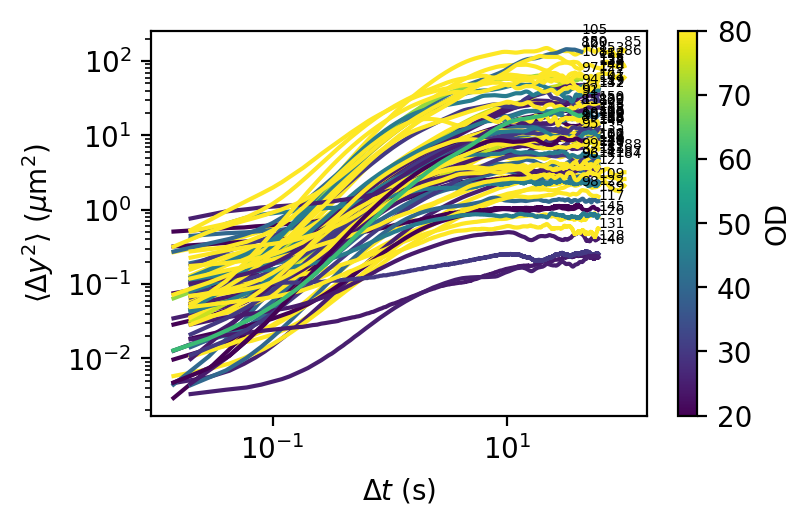

In [60]:
# plot MSD, filter out the suspicious ones
plt.figure(figsize=(4, 2.5), dpi=200)
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
for num, i in log1.iterrows():
    nDE = int(num)
    if nDE in suspicious_traj:
        continue
    plt.plot(msd_list[nDE].lagt, msd_list[nDE]["<y^2>"], color=viridis(norm(i.OD)), label=nDE)
    plt.annotate(nDE, (msd_list[nDE].iloc[-1, 5], msd_list[nDE].iloc[-1, 4]), xycoords="data", fontsize=5)
plt.loglog()
plt.xlabel("$\Delta t$ (s)")
plt.ylabel("$\langle \Delta y^2 \\rangle$ ($\mu$m$^2$)")
sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, label="OD")

### 2.3 Collapse MSD using fitting parameters $D_A$ and $\tau^*$

Text(0, 0.5, '$\\langle \\Delta y^2 \\rangle / D_A\\tau^*$')

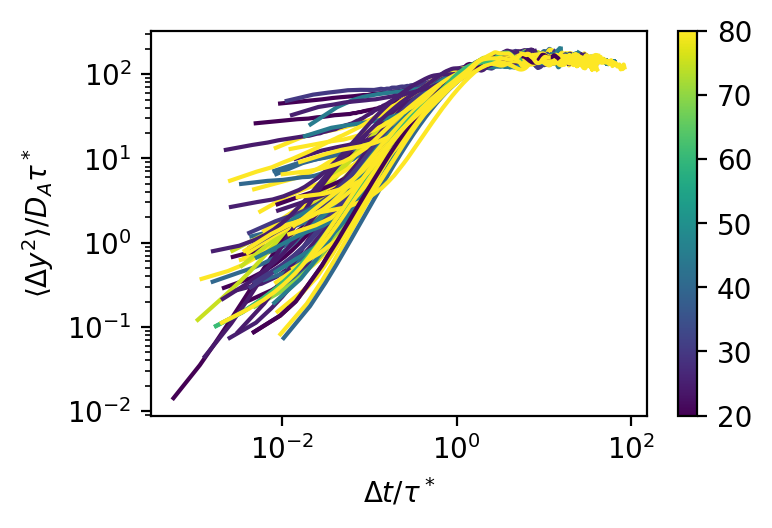

In [61]:
# plot rescaled MSD, collapse
log2 = log1#.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax)
for num, i in log2.iterrows():
    nDE = int(num)
    if nDE in suspicious_traj:
        continue
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    ax.plot(msd_list[nDE].lagt/t2, msd_list[nDE]["<y^2>"]/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd_list[nDE]) != 0:
#         ax.annotate(nDE, 
#                      [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
#                      xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

### 2.4 Collapse MSD and correct short time subdiffusive regime

Text(0, 0.5, '$\\langle \\Delta y^2 \\rangle / D_A\\tau^*$')

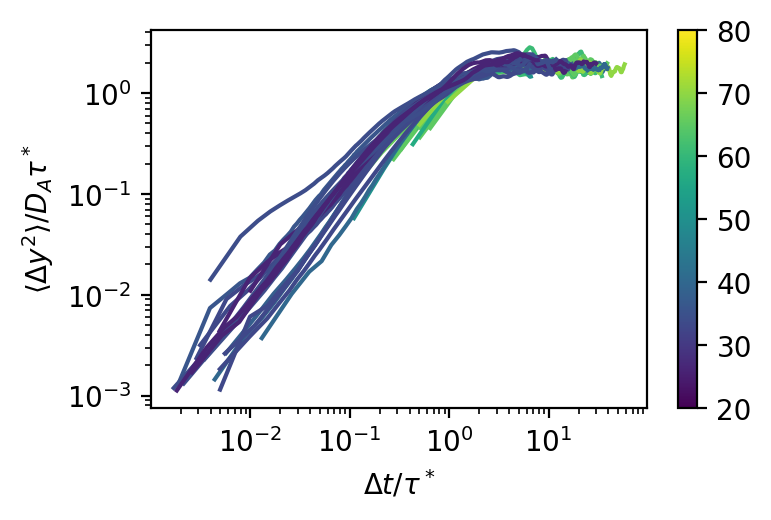

In [21]:
# plot rescaled and corrected MSD, subdiffive regime should disappear
log2 = log1.dropna(subset=["t2_fit", "DA_fit"])
count = 0
norm = colors.Normalize(vmin=20, vmax=80)
viridis = plt.cm.get_cmap("viridis")
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

sm = cm.ScalarMappable(norm=norm, cmap="viridis")
plt.colorbar(sm, ax=ax)
for num, i in log2.iterrows():
    nDE = int(num)
    if nDE in suspicious_traj:
        continue
    t2 = i["t2_fit"]
    DA = i["DA_fit"]
    msd = msd_list[nDE]
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    if nDE <= 80:
        offset = 0
    ax.plot(msd.lagt/t2, (msd["<y^2>"] - offset)/DA/t2, 
             color=viridis(norm(i.OD)), label=nDE)
    count += 1
#     if len(msd_list[nDE]) != 0:
#         ax.annotate(nDE, 
#                      [msd_list[nDE].lagt.iloc[0]/t2, msd_list[nDE]["<y^2>"].iloc[0]/DA/t2],
#                      xycoords="data", fontsize=5)    
ax.loglog()
ax.set_xlabel("$\Delta t/\\tau^*$")
ax.set_ylabel("$\langle \Delta y^2 \\rangle / D_A\\tau^*$")

## 3 Fit MSD curves

**unambiguous measurement of $R_\infty$ and $\tau^*$**

Previously, I use hand fitting to roughly measure the saturation time $\tau^*$ and displacement $R_\infty$ of inner droplet MSD. While this technique allow quick data extraction, the measurement is ambiguous and inaccurate for a careful data analysis. Therefore, I now use real curve fitting to extract these values. I use the formula from Maggi et al. 2014 for the first test
$$
\left< \Delta y^2(t) \right> = \frac{2D_A}{\mu k} \frac{1-e^{-\mu kt} - \mu k\tau(1-e^{-t/\tau})}{1-(\mu k\tau)^2}
$$
To make the two time scales more apparent, let $\mu k = 1/\tau^*$ :
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

### 3.1 Preprocessing of MSD data

In the past, we have tried to smooth the trajectory data and then compute MSD. While this approach can successfully eliminate the subdiffusive regime in the MSD, it always creates an artificial ballistic regime. Even worse, if the smooth window size is not chosen properly, the artificial time scale can overwrite the time scale from the measurement, making the measurement meaningless.

Hence, we seek a threoretical approach based on reasonable assumptions to minimize the impact of detection noise, while keeping other key features unchanged.

Briefly, if we assume the detection noise of droplets $\sigma$ is additive to the real position
$$
y_i = x_i + \sigma_i,
$$
where $\sigma_i$ is assumed to be random and uncorrelated in time, i.e.
$$
\left< \sigma \right> = 0, \, \left< \sigma_i\sigma_j \right> = A\delta_{ij},
$$
the effect of noise $\sigma$ on the mean square displacement is just a constant offset:
$$
\left< \Delta y^2 \right> = \left<\Delta x^2\right> + 2A
$$

We can evaluate this equation at $\Delta t = 0$, where $\Delta x^2 = 0$ is true, to get the value of $A$:
$$
2A = \left< \Delta y^2 \right>_{\Delta t=0}
$$

For full details, refer to the note [Deal with detection noise](../Notes/2022-07-21_deal-with-detection-noise.pdf) 

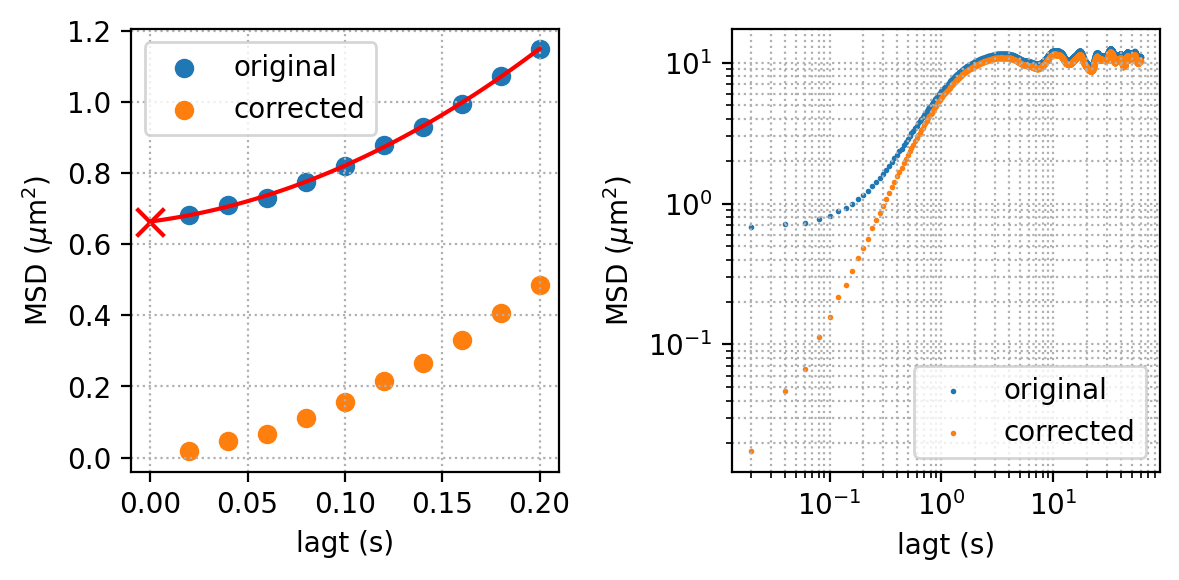

In [38]:
# load data
i = 171
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# compute MSD
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=3000)
msd = msd.dropna()
# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

# Extrapolate offset visualization
ax[0].scatter(x, y, label="original")
ax[0].plot(xfit, yfit, color="red")
ax[0].scatter(xfit[0], yfit[0], marker="x", color="red", s=100)
ax[0].scatter(x, y-offset, label="corrected")
ax[0].set_xlabel("lagt (s)")
ax[0].set_ylabel("MSD ($\mu$m$^2$)")
ax[0].grid(which="both", ls=":")
# ax[0].set_xlim([0, 0.15])
# ax[0].set_ylim([0, 0.1])
ax[0].legend()

# Original and corrected MSD
ax[1].scatter(msd.lagt, msd["<y^2>"], color=bestcolor(0), label="original", s=1)
ax[1].scatter(msd.lagt, msd["<y^2>"] - offset, 
            label="corrected", color=bestcolor(1), s=1)
ax[1].set_xlabel("lagt (s)")
ax[1].set_ylabel("MSD ($\mu$m$^2$)")
ax[1].loglog()
ax[1].grid(which="both", ls=":")
ax[1].legend()

plt.tight_layout()

#### Aside: artificial traj with short time noise to reproduce the subdiffusive regime at short times

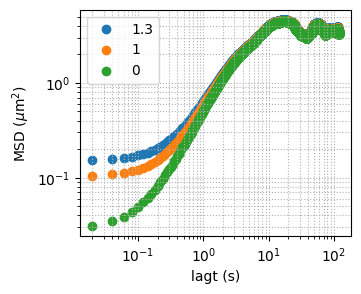

In [459]:
i = 175
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# traj.y = gaussian_filter1d(traj.y, sigma=3/4)

plt.figure(figsize=(3.5, 3), dpi=100)
for noise in [1.3, 1, 0]:
    t = traj.copy()
    t.x += (2 * np.random.rand(len(t)) - 1) * noise
    t.y += (2 * np.random.rand(len(t)) - 1) * noise
    msd = tp.msd(t, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
    msd = msd.dropna()
    plt.scatter(msd.lagt, msd["<y^2>"], label=noise)

plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")
plt.legend()

### 3.2 Direct fitting

Let us try first to directly fit the MSD data using the 3-parameter Langevin model
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*(1-e^{-t/\tau})}{1-(\tau/\tau^*)^2}
$$

In [68]:
def msd_model(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return dy2

t1=3.26 s, t2=3.26 s, DA=133.53 um^2/s


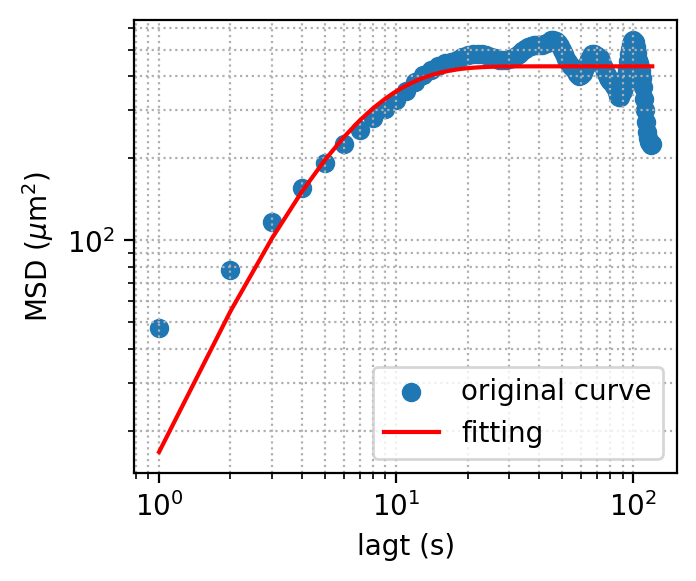

In [463]:
popt, pcov = curve_fit(msd_model, new_msd.lagt, new_msd["<y^2>"], p0=[100, 0.1, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 3.3 Fit the log data

The MSD data span more than 3 orders of magnitude. When we fit directly by minimizing the least square, the small MSD regime does not fit well. This is because at small scale, even if the fitting deviates from data by 100%, the absolute square error is nothing compared to a small deviation at large scales. To make both small and large scale fitting important, we take a log of the MSD data to make the numbers to be fitted on the same order of magnitude. 

In [63]:
# try to fit log data
def msd_model_log(lagt, DA, tau, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star*(1-np.exp(-lagt/tau))) / (1 - (tau/tau_star)**2)
    return np.log(dy2)

t1=0.55 s, t2=0.55 s, DA=19.03 um^2/s


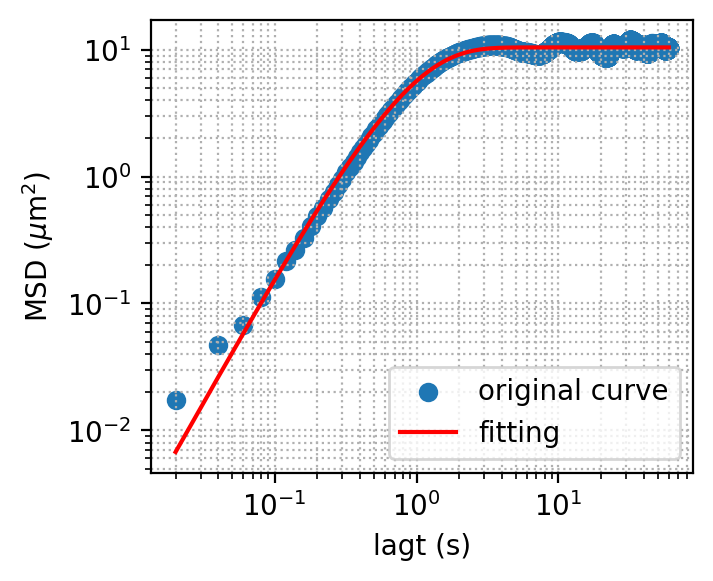

In [42]:
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), 
                       p0=[100, 0.1, 1])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD ($\mu$m$^2$)")
plt.loglog()
plt.grid(which="both", ls=":")

### 3.4 Simple 2-parameter model, fix $\tau=0.15$ s (deprecated)

$\tau = 0.15$ s is a characteristic time scale of bacterial dynamics, estimated from the length of bacteria $l_b\approx 3$ $\mu$m and the swimming speed of bacteria $v_b\approx 20$ $\mu$m/s:
$$
\tau = \frac{l_b}{v_b} = 0.15 \:\text{s}
$$
We also assume that $t\gg\tau$, so that $e^{-t/\tau}\to 0$. This leads to a simplified model with only two fitting parameters $D_A$ and $\tau^*$: (keeping the $e^{-t/\tau}$ term leads to difficulty in fitting)
$$
\left< \Delta y^2(t) \right> = 2D_A\tau^* \frac{1-e^{-t/\tau^*} - \tau/\tau^*}{1-(\tau/\tau^*)^2}
$$

In [223]:
def msd_model_simp(lagt, DA, tau_star):
    """This is the mean square displacement predicted by the langevin model with exponentially correlated active noise.
    """
    tau = 0.15
    dy2 = 2*DA*tau_star * (1-np.exp(-lagt/tau_star) - tau/tau_star) / (1 - (tau/tau_star)**2)
    return dy2

t2=3.56 s, DA=0.53 um^2/s


[]

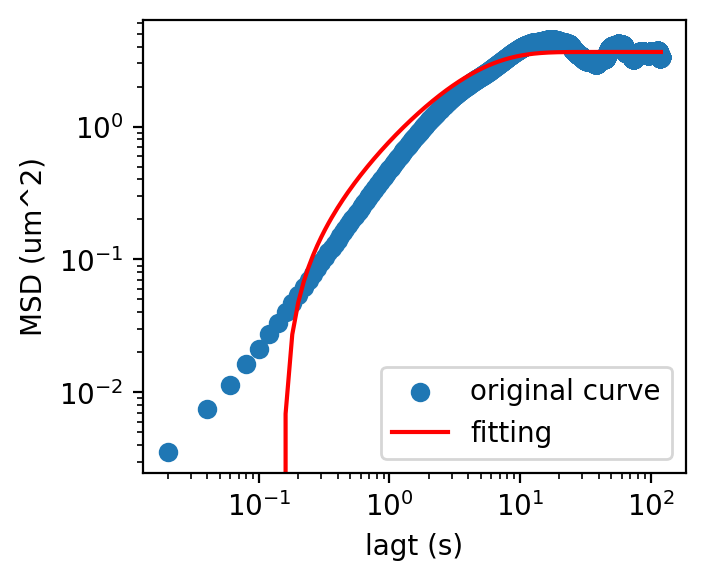

In [225]:
popt, pcov = curve_fit(msd_model_simp, new_msd.lagt, new_msd["<y^2>"], p0=[1, 5])
print("t2={1:.2f} s, DA={0:.2f} um^2/s".format(popt[0], popt[1]))
plt.figure(figsize=(3.5, 3), dpi=200)
plt.scatter(new_msd.lagt, new_msd["<y^2>"], label="original curve")
plt.plot(msd.lagt, msd_model_simp(msd.lagt, *popt), label="fitting", color="red")
plt.legend()
plt.xlabel("lagt (s)")
plt.ylabel("MSD (um^2)")
plt.loglog()

<font color="blue">The fitting works pretty well for the long time limit. However, in the short time regime, due to our approximation, the fitting goes off. Now that we are able to get full trajectories, we deprecate this simple model fitting and switch to original model fitting.</font>

### 3.5 Fit all the MSD data and generate MSD fitting repo

Using the reduced model, we fit all the MSD curves and extract more accurate and unambiguous $D_A$ and $\tau^*$. To be able to check the fitting quality later, I save all the fitting plots in the MSD repo so I can come back at any time. 

<font color="red">The block below plots MSD fittings and save results as pictures in "Pictures" folder!</font>

In [62]:
log1

,Date,Video#,MPP,FPS,OD,D,D_err,d,d_err,Easy to analyze?,...,t1_fit,t2_fit,DA_fit,(D-d)/d,DA/OD,c,number of bacteria,mean velocity (1s),mean velocity middle,mean velocity end
DE#,,,,,,,,,,,,,,,,,,,,,
81,NaT,experimento201020_DE_60x_od61_70fps_exp_002,0.11,70.0,61,38.3,NaN,12.1,NaN,NaN,...,NaN,8.048422,0.015487,2.165289,0.000254,0.252369,1389.567179,NaN,NaN,NaN
82,NaT,experimento201020_DE_60x_od83_70fps_exp_4_002,0.11,70.0,83,46.3,NaN,7.9,NaN,NaN,...,NaN,3.795602,0.106920,4.860759,0.001288,0.076638,3431.837488,NaN,NaN,NaN
83,NaT,experimentoDE_7_11_19_30fps_60x_exp2_1003,0.11,30.0,94,57.1,NaN,11.4,NaN,NaN,...,NaN,3.441970,0.247953,4.008772,0.002638,0.096355,7268.329443,NaN,NaN,NaN
84,NaT,experimentoDE_7_11_19_30fps_60x_exp3003,0.11,30.0,170,45.9,NaN,12.0,NaN,NaN,...,NaN,6.878155,0.001884,2.825000,0.000011,0.117170,6759.657369,NaN,NaN,NaN
85,NaT,experimentoDE_15_10_19_30fps_exp2_60x003,0.11,30.0,100,57.3,NaN,12.4,NaN,NaN,...,NaN,3.704945,0.149033,3.620968,0.001490,0.021144,7796.657387,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,NaT,experimentoexp_od125_60x_50fps_1003,0.11,50.0,125,90.8,NaN,42.6,NaN,NaN,...,NaN,1.481641,0.038977,1.131455,0.000312,0.065855,35131.604051,NaN,NaN,NaN
157,NaT,experimentoVideos_2020DE_60x_70fps_OD_17_exp002,0.11,70.0,17,40.4,NaN,13.4,NaN,NaN,...,NaN,2.970658,0.018288,2.014925,0.001076,0.027666,452.186677,NaN,NaN,NaN
158,NaT,experimentoVideos_2020201020_DE_60x_od61_70fps...,0.11,70.0,61,38.3,NaN,12.1,NaN,NaN,...,NaN,8.048422,0.015487,2.165289,0.000254,0.050780,1389.567179,NaN,NaN,NaN


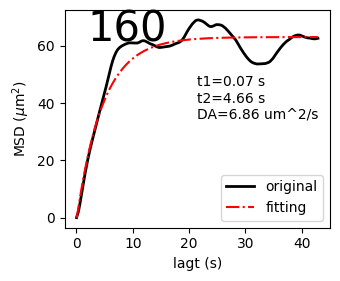

In [157]:
traj_folder = os.path.join(data_folder, "traj")
fig_folder = r"C:\Users\liuzy\Pictures"
# log1 = log.loc[log.Comment!="Chile"]
count = 0
DE_list = [] # DE# list
DA_list = [] # container for fitted D_A values
tau_list = [] # container for fitted tau values
for num, i in log1.iterrows():
    nDE = int(num)
    # filtering conditions
    # if nDE <= 160 or nDE in suspicious_traj:
    #     continue
    if os.path.exists(os.path.join(traj_folder, "{:02d}.csv".format(num))) == False:
        continue
#     traj = pd.read_csv(os.path.join(traj_folder, "{:02d}.csv".format(i["DE#"])))
#     msd = tp.msd(traj, mpp=i.MPP, fps=i.FPS, max_lagtime=traj.frame.max()//5)
#     msd = msd.dropna()    
    msd = msd_list[nDE]
    
    # obtain offset
    x = msd.lagt.iloc[:10]
    y = msd["<y^2>"].iloc[:10]
    p = np.polyfit(x, y, 2)
    xfit = np.linspace(0, 0.2)
    yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
    offset = yfit[0]
    try:
        popt, pcov = curve_fit(msd_model_log, msd.lagt, np.log(msd["<y^2>"]-offset), p0=[4, .01, 5])
    except:
        continue
    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=100)
    ax.plot(msd.lagt, msd["<y^2>"]-offset, color="black", lw=2, label="original")
    ax.plot(msd.lagt, msd_model(msd.lagt, *popt), color="red", ls="-.",label="fitting")
    ax.legend(loc="lower right")
    ax.set_xlabel("lagt (s)")
    ax.set_ylabel("MSD ($\mu$m$^2$)")
    ax.annotate("{:d}".format(num), (.25, .8), xycoords="figure fraction", fontsize=30)
    ax.annotate("t1={0:.2f} s\nt2={1:.2f} s\nDA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]), 
                (.5, .5), xycoords="axes fraction", fontsize=10)
    # ax.loglog()
    plt.tight_layout()
    plt.pause(0.01)
    fig.savefig(os.path.join(fig_folder, "lin{:d}.jpg".format(num)))
    clear_output(wait=True)
    plt.close()
    count += 1
    if count > 10000:
        break

### 3.6 Weighted fitting

The small time region has sparser data, so even if I take a log to the whole data and fit, the small time region still play less role than the larger time region, leading to bad fitting quality at small times, and unprecise determination of $t_1$. To fix this problem, we introduce weighted fitting to put more weight on the small times. 

Since the density of points gets larger exponentially, we put weight as an exponential decay:
$$
w(t) = e^{-t/\tau_c}
$$

In `scipy.curve_fit()`, weight is not set directly. The uncertainty `sigma` is similar to the role of weight. It allows me to specify the uncertainty of each data point. Data point with smaller uncertainty is trusted more, so in effect more weight is put on it. Therefore, we set the uncertainty `sigma` as the inverse of our intended weight $w(t)$:
$$
\sigma = 1 - w(t) = 1 - e^{-t/\tau_c}
$$

In [433]:
# load data
i = 175
logi = log.loc[i]
traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i))).dropna()
# compute MSD
msd = tp.msd(traj, mpp=float(logi.MPP), fps=float(logi.FPS), max_lagtime=6000)
msd = msd.dropna()
# determine offset using extrapolation
x = msd.lagt.iloc[:10]
y = msd["<y^2>"].iloc[:10]
p = np.polyfit(x, y, 2)
xfit = np.linspace(0, 0.2)
yfit = p[0] * xfit ** 2 + p[1] * xfit + p[2]
offset = yfit[0]
# create new_msd
new_msd = msd.copy()
new_msd["<y^2>"] -= offset

In [434]:
# sigma = 2*np.ones(len(new_msd))
# sigma[:20] = 1
sigma = 1 - np.exp(-new_msd.lagt)

C:\Users\liuzy\Miniconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


t1=0.29 s, t2=4.04 s, DA=0.48 um^2/s
t1=0.02 s, t2=9.59 s, DA=0.19 um^2/s


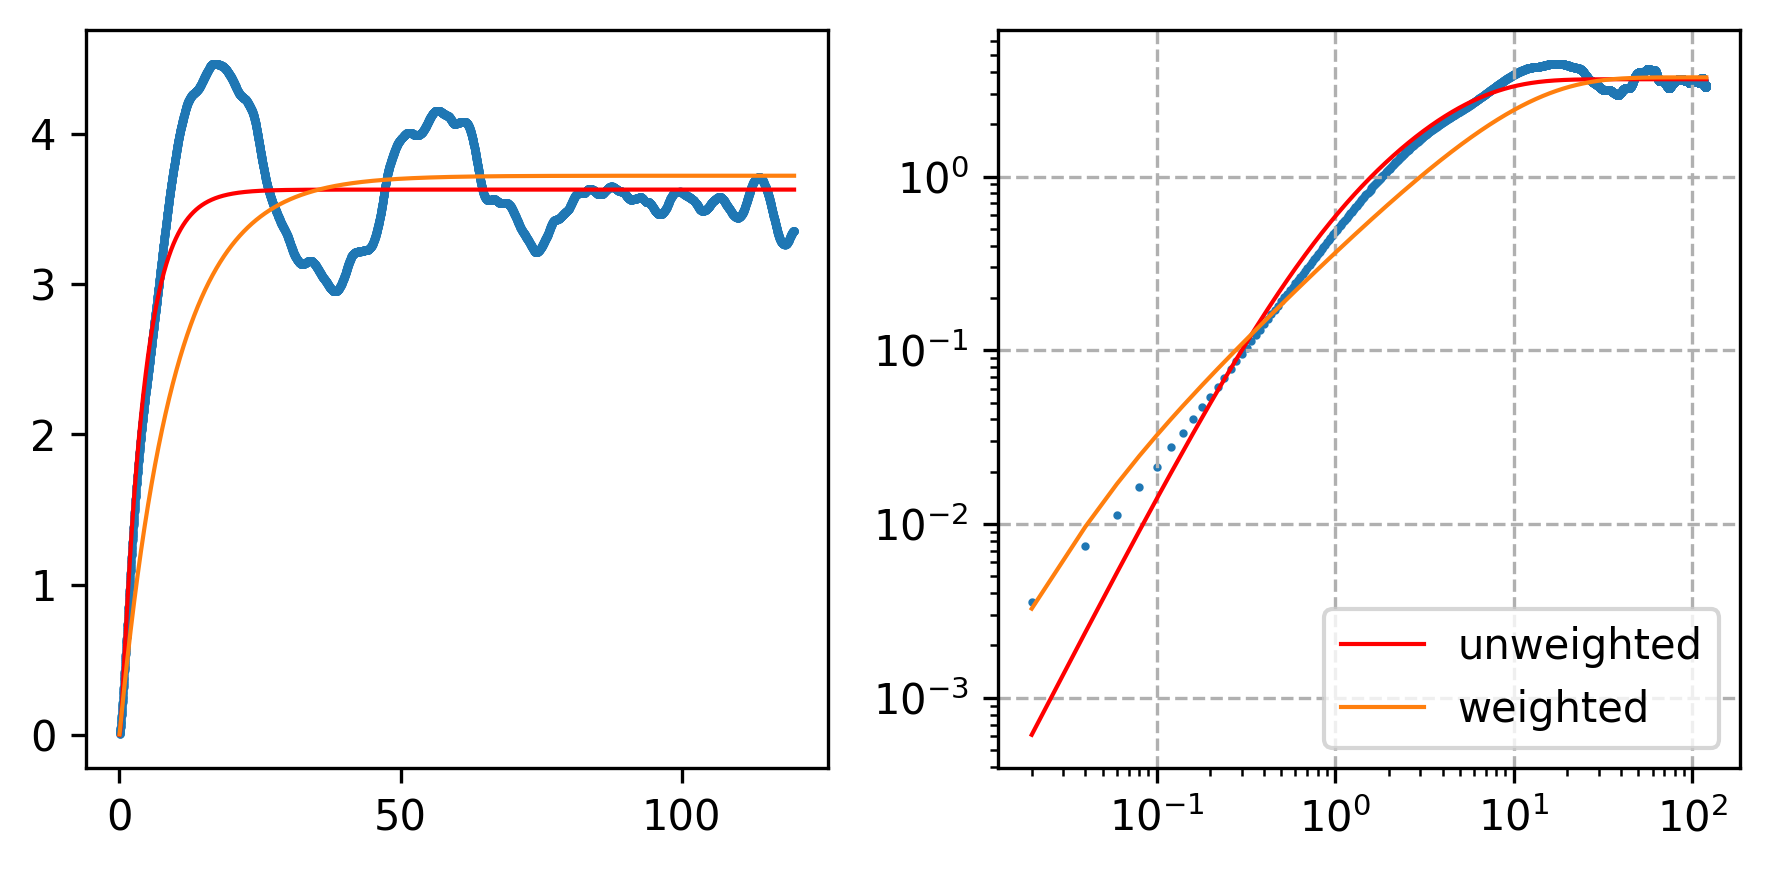

In [435]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
ax[0].scatter(new_msd.lagt, new_msd["<y^2>"], s=1)
ax[1].scatter(new_msd.lagt, new_msd["<y^2>"], s=1)
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), p0=[1, 0.01, 4])
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))
ax[0].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color="red", lw=1)
ax[1].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color="red", label="unweighted", lw=1)
popt, pcov = curve_fit(msd_model_log, new_msd.lagt, np.log(new_msd["<y^2>"]), p0=popt, sigma=sigma)
ax[0].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color=bestcolor(1), lw=1)
ax[1].plot(new_msd.lagt, msd_model(new_msd.lagt, *popt), color=bestcolor(1), label="weighted", lw=1)
ax[1].loglog()
ax[1].legend()
ax[1].grid(ls="--")
print("t1={0:.2f} s, t2={1:.2f} s, DA={2:.2f} um^2/s".format(popt[1], popt[2], popt[0]))

plt.tight_layout()

<font color="blue"> The plots above compares unweighted fitting and weighted fitting. From the linear plot (left), we can see that the weighted fitting does not capture the crossover to saturation accurately. From the loglog plot (right), we can see that the weighted fitting captures the first several data points better. Taken together, the weighted fitting does not improve the most important aspect of the fitting, which is to capture the transition time accurately. Therefore, we stay on the unweighted fitting, and ignore the deviation in the small time limit.</font>

## 4 Geometry and concentration dependence

We obtain 3 fitting parameters from the MSD fitting: $D_A$, $\tau$ and $\tau^*$. In this section, we discuss the geometry implication from the spring model, and compare with our measurements. 

### 4.1 $D_A$, the active diffusivity

In the spring model, $D_A$ is a quantity that describes the strength of "active noise", resembling the thermal diffusivity $D_T$ in Brownian motion. In our model, there is no explicit dependence on the outer diameter $D$. From the Stokes-Einstein relation for Brownian motion
$$
D_T = \frac{k_BT}{6\pi\eta a},
$$
however, we infer that $D_A$ has a dependence on the inner droplet size (probe size), i.e. 
$$
D_A \propto \frac{1}{d}.
$$

Here, we plot
- $D_A$ vs. $D$ to see if $D$ is irrelevant
- $D_A$ vs. $d$ to see if the $-1$ exponent exists
- $D_A$ vs. $D-d$ to see if the free space is the actual control parameter
- $D_A$ vs. $(D-d)/d$ to show the best control parameter we have identified

In [8]:
# prepare data, only include OD in [20, 80] and exclude suspicious data
log1 = log.loc[(log.Comment!="Chile")&(log.OD<=80)&(log.OD>20)].drop(suspicious_traj)
dd1 = de_data(log1)

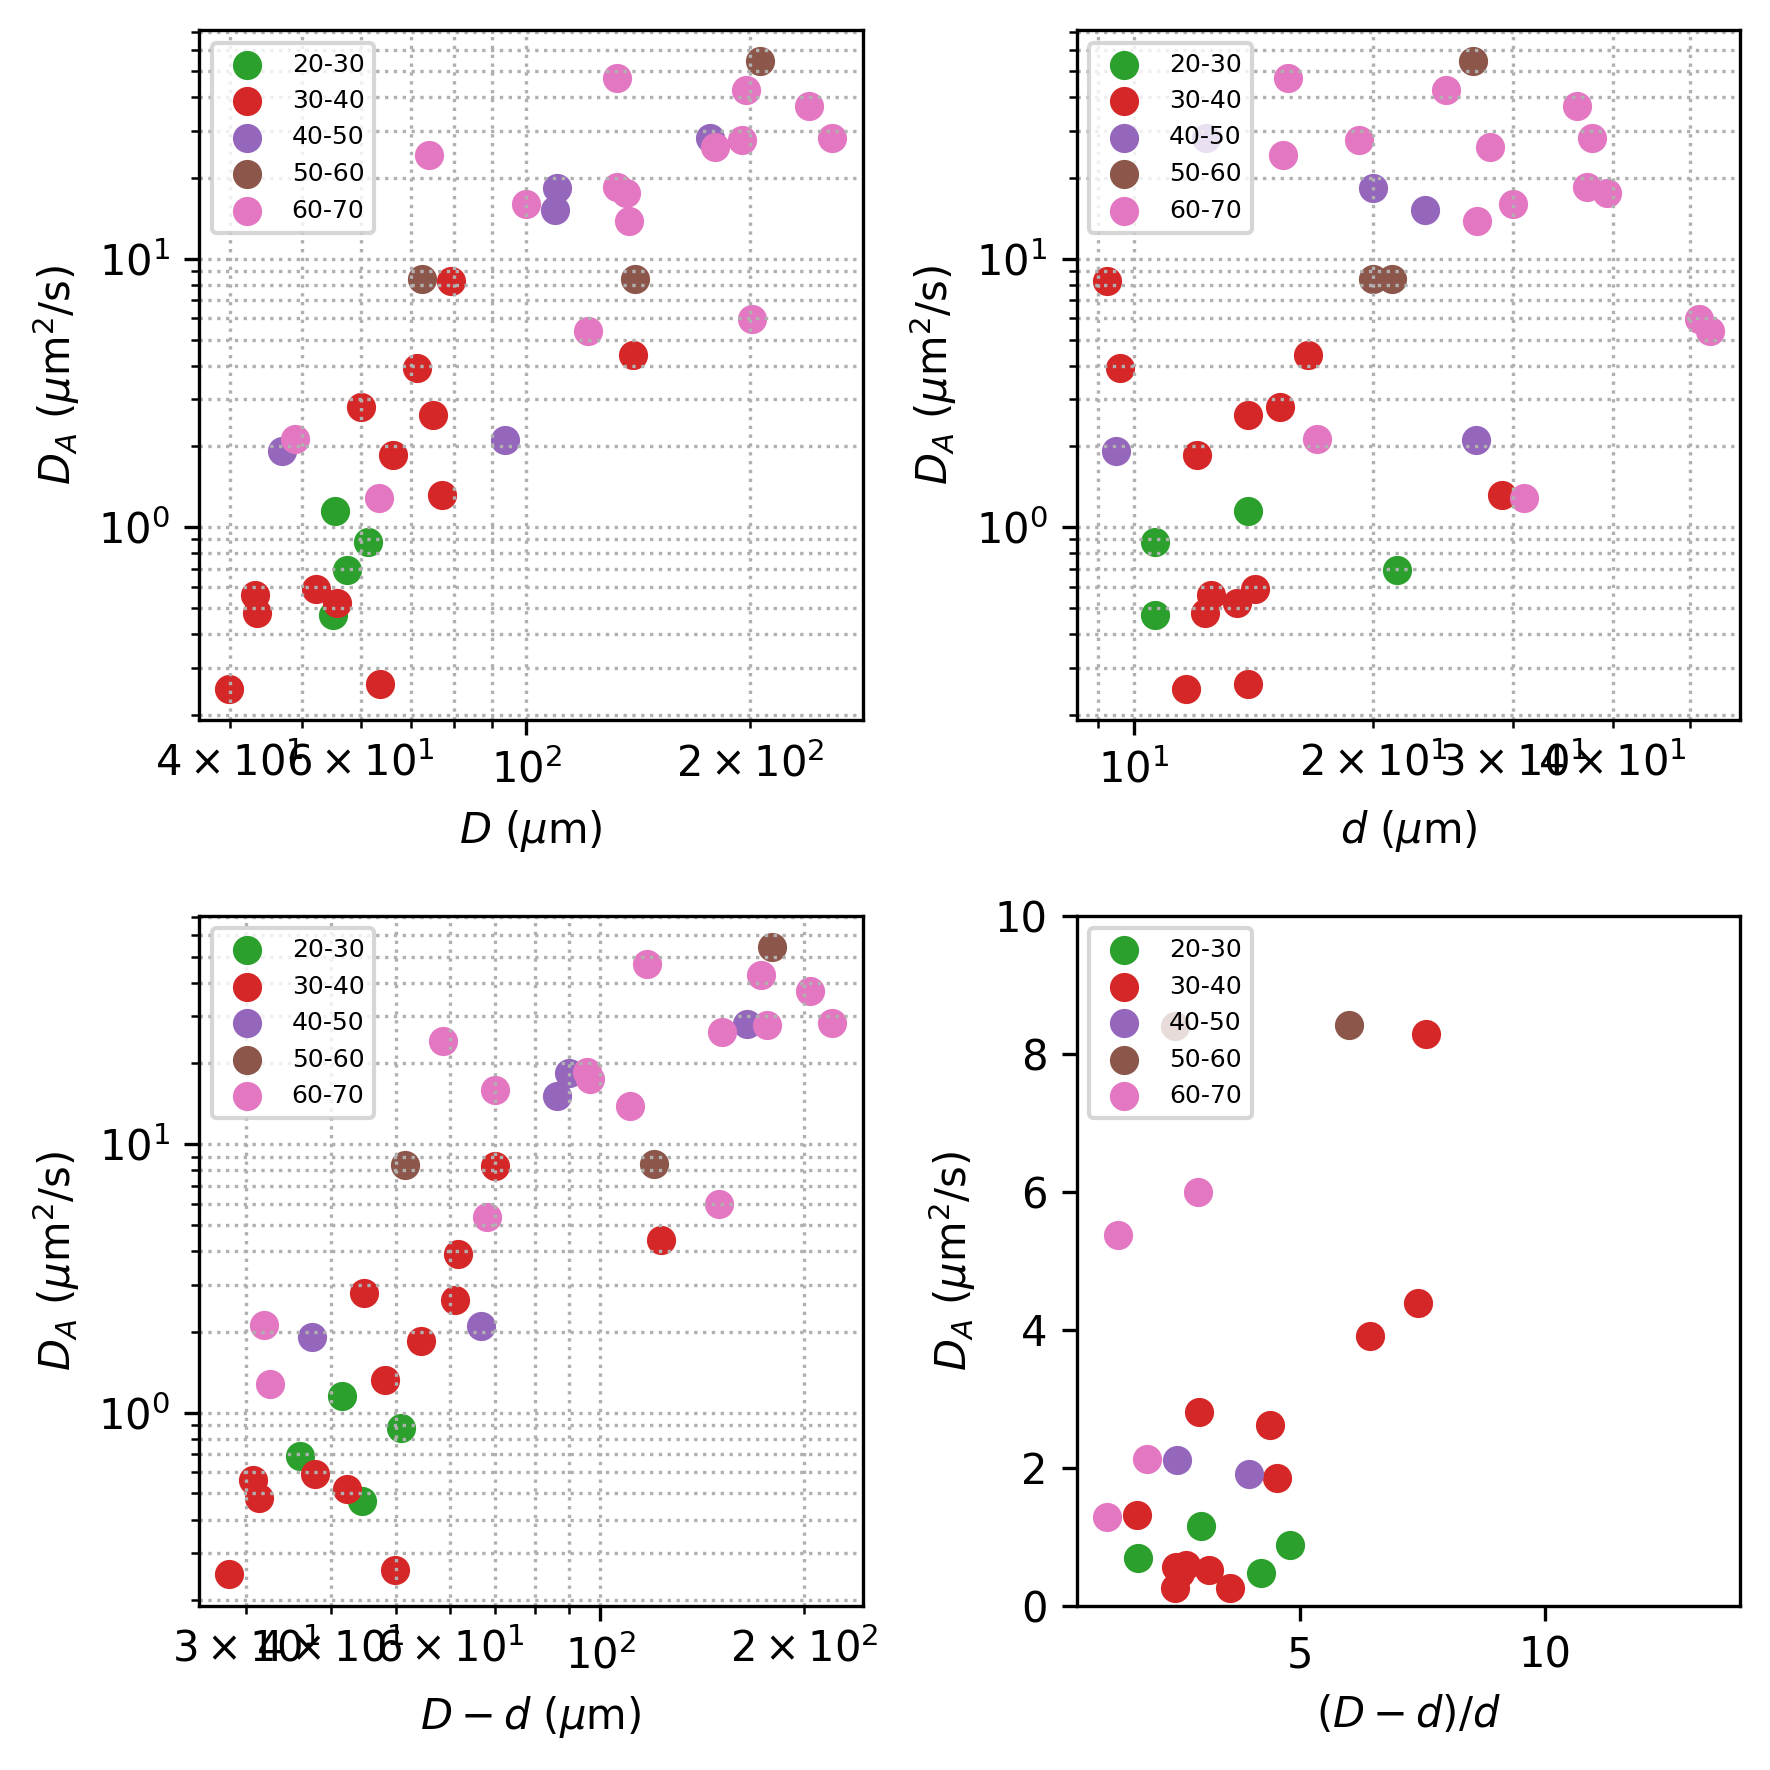

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
dd1.scatter(x="D", y="DA_fit", xlabel="$D$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[0][0])
dd1.scatter(x="d", y="DA_fit", xlabel="$d$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[0][1])
dd1.scatter(x="D-d", y="DA_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="log", ax=ax[1][0])
dd1.scatter(x="(D-d)/d", y="DA_fit", xlabel="$(D-d)/d$", ylabel="$D_A$ ($\mu$m$^2$/s)", mode="lin", ax=ax[1][1])
ax[1][1].set_ylim([0, 10])
plt.tight_layout()

#### Concentration dependence of $D_A$

From the $D_A$ vs. $(D-d)/d$ plot, we can see a pronounced concentration dependence of $D_A$: low concentration points are below the high concentration points! What is the exact nature of this dependence? Let's choose a small range of $(D-d)/d$, and plot $D_A$ as a function of OD.

[]

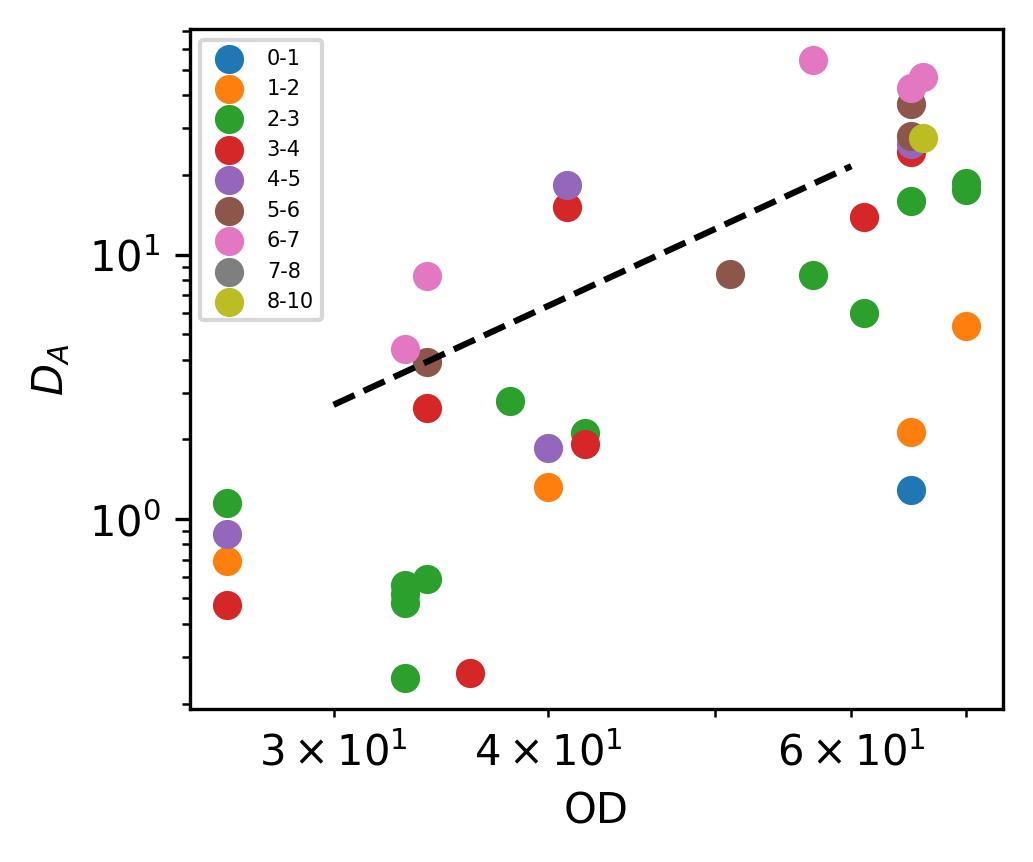

In [478]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=300)
d_bins = np.linspace(0, 10, 10)
binsize = d_bins[1] - d_bins[0]
for start in d_bins[:-1]:
    end = start + binsize
    sublog = log1.loc[(log["(D-d)/d"]>=start)&(log["(D-d)/d"]<end)]
    ax.scatter(sublog.OD, sublog.DA_fit, label="{0:d}-{1:d}".format(int(start), int(end)))
ax.legend(loc="upper left", fontsize=5)
ax.set_xlabel("OD")
ax.set_ylabel("$D_A$")
# ax.set_xlim([0, 80])
# ax.set_ylim([0, 30])
x = np.array([30, 60])
y = 0.0001 * x ** 3
ax.plot(x, y, color="black", ls="--")
ax.loglog()

### 4.2 $\tau$, correlation time of "active noise"

<font color="blue">This data set currently only contains OD in [20, 40], complete $\tau$ data in the future. </font>

$\tau$ is the correlation time of the stochastic "active noise". When lag time is greater than $\tau$, the correlation between the noise at different times vanishes. The model does not provide explicit prediction on this value. In fact, it is assumed a constant, independent of both bacterial concentration and geometry.

Here, we plot
- $\tau$ vs. $D$
- $\tau$ vs. $d$
- $\tau$ vs. $D-d$
- $\tau$ vs. $(D-d)/d$, I don't know why but just to fill the panels

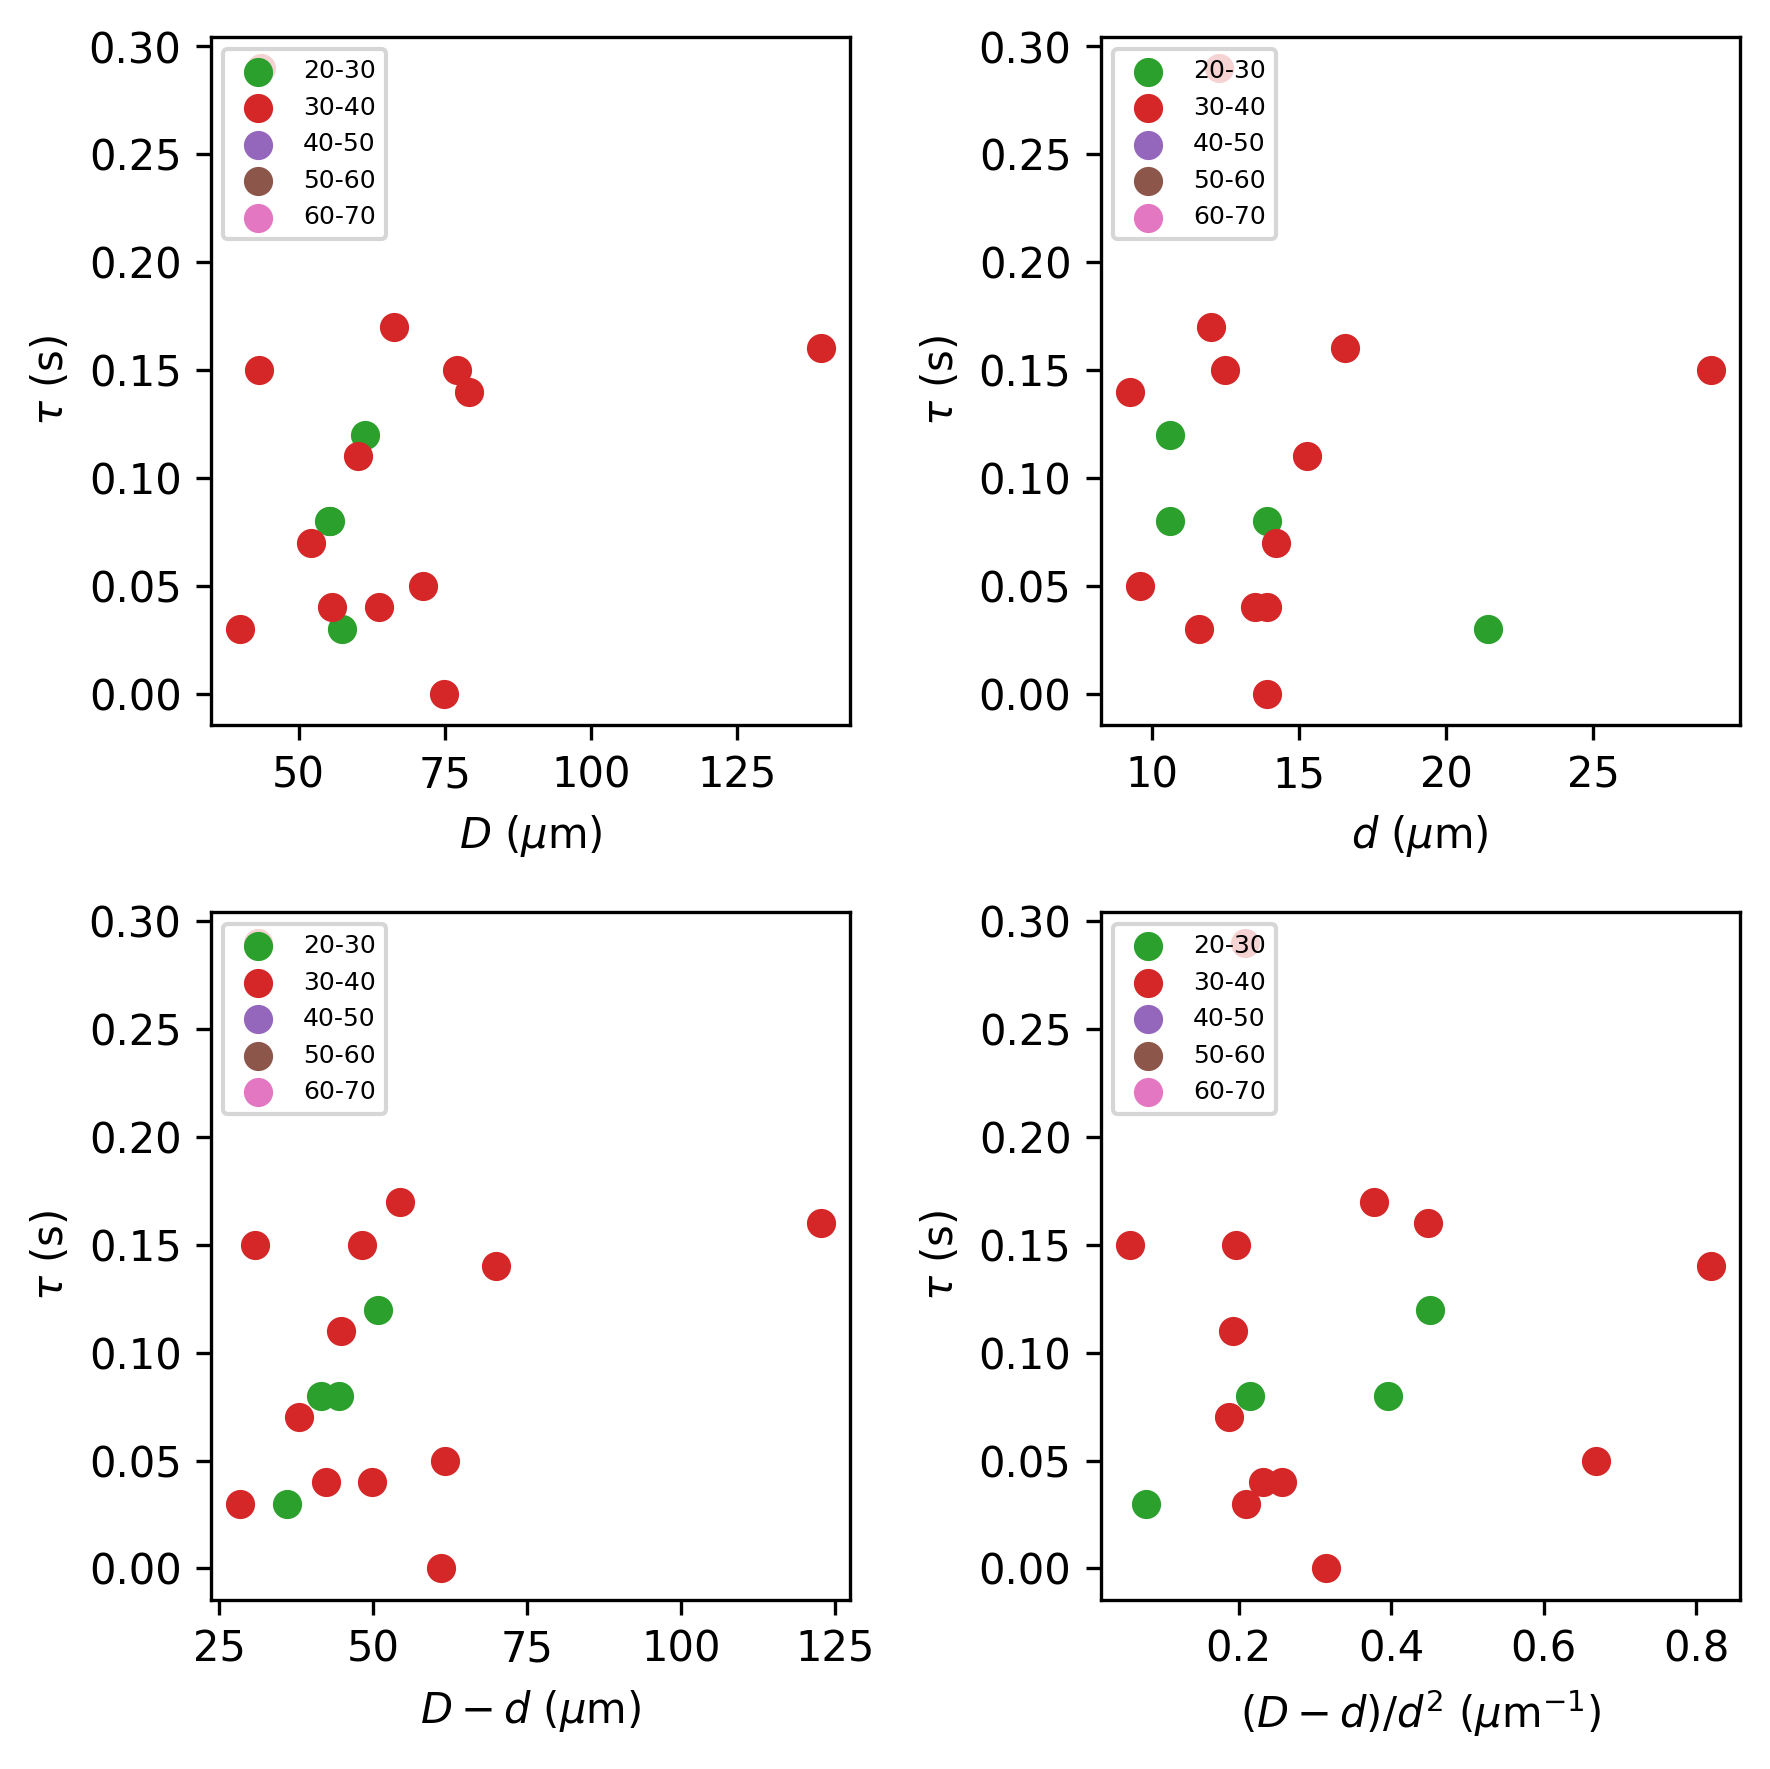

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
dd1.scatter(x="D", y="t1_fit", xlabel="$D$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[0][0])
dd1.scatter(x="d", y="t1_fit", xlabel="$d$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[0][1])
dd1.scatter(x="D-d", y="t1_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[1][0])
dd1.scatter(x="(D-d)/d^2", y="t1_fit", xlabel="$(D-d)/d^2$ ($\mu$m$^{-1}$)", ylabel="$\\tau$ (s)", mode="lin", ax=ax[1][1])
plt.tight_layout()

#### Concentration dependence

(0.0, 0.3)

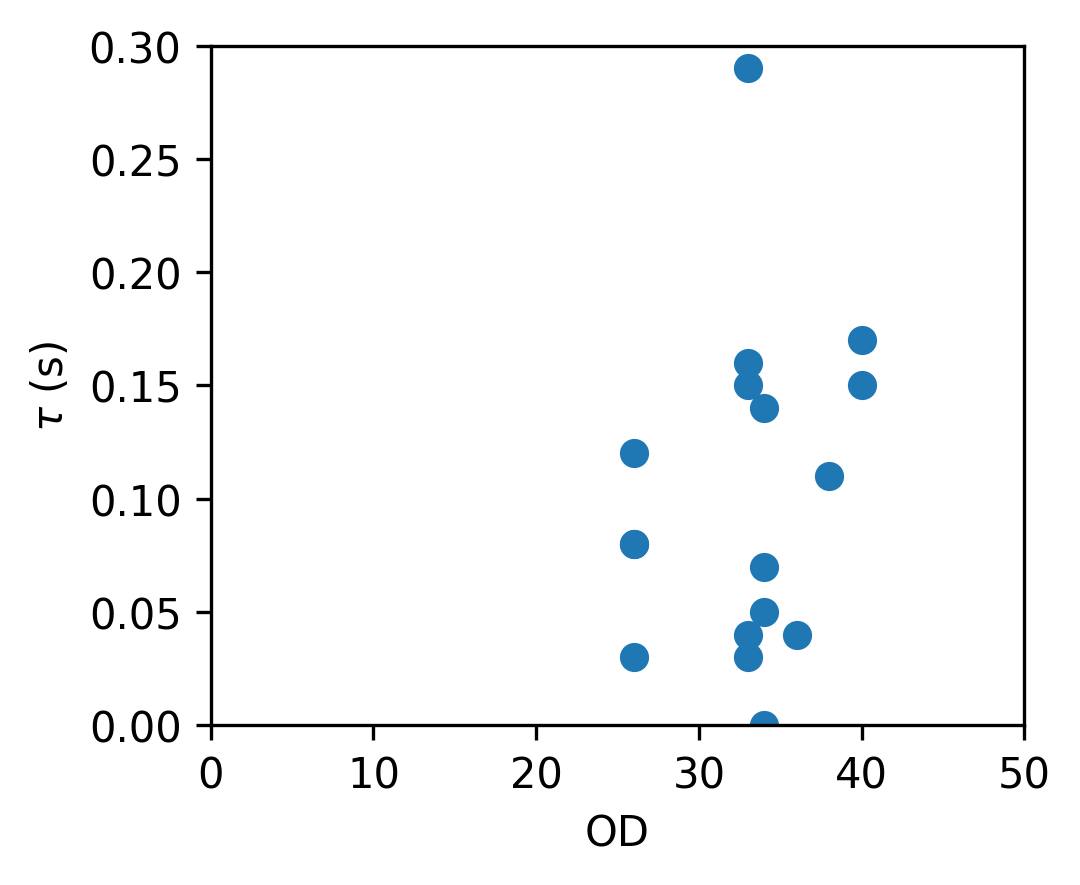

In [430]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=300)
ax.scatter(log1.OD, log1.t1_fit)
ax.set_xlabel("OD")
ax.set_ylabel("$\\tau$ (s)")
ax.set_xlim([0, 50])
ax.set_ylim([0, .30])

### 4.3 $\tau^*$, relaxation time of the confined fluctuation

The spring model predicts the relaxation time $\tau^*$ as:
$$
\tau^* = \frac{9\eta}{\Delta\rho g}\frac{D-d}{d^2}.
$$
This prediction is rather quantitative and therefore easy to verify. More interestingly, $\tau^*$ is independent of bacterial concentration, which provides additional qualitative measure for verifying the prediction.

Here, we plot
- $\tau^*$ vs. $D$
- $\tau^*$ vs. $d$
- $\tau^*$ vs. $D-d$
- $\tau^*$ vs. $(D-d)/d^2$ as predicted

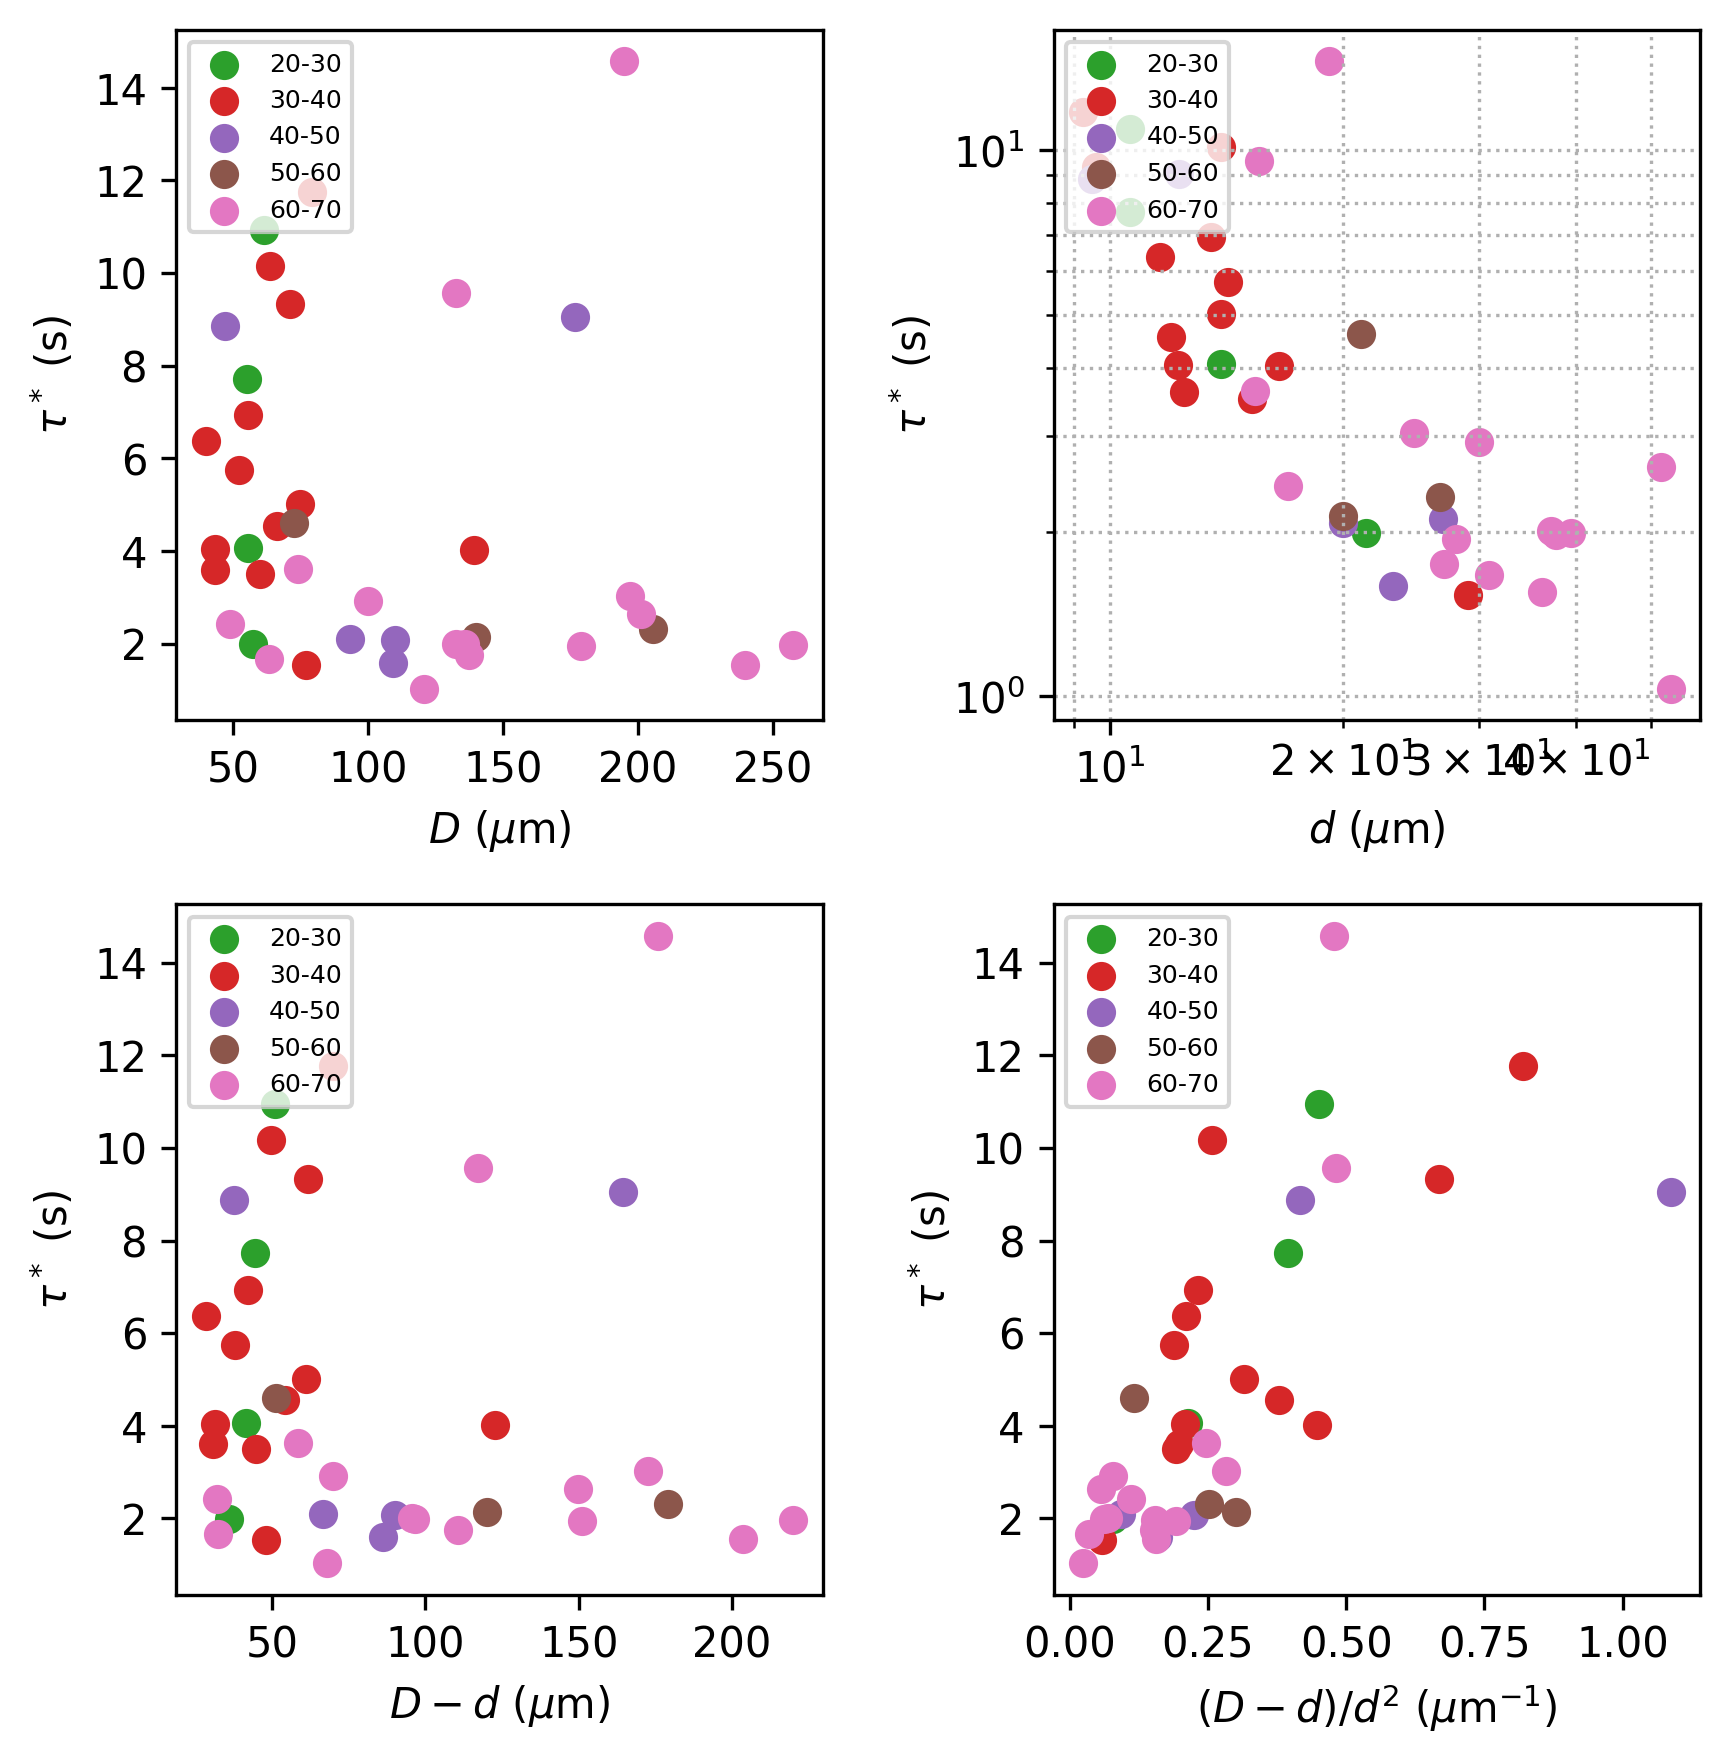

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
dd1.scatter(x="D", y="t2_fit", xlabel="$D$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[0][0])
dd1.scatter(x="d", y="t2_fit", xlabel="$d$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="log", ax=ax[0][1])
dd1.scatter(x="D-d", y="t2_fit", xlabel="$D-d$ ($\mu$m)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[1][0])
dd1.scatter(x="(D-d)/d^2", y="t2_fit", xlabel="$(D-d)/d^2$ ($\mu$m$^{-1}$)", ylabel="$\\tau^*$ (s)", mode="lin", ax=ax[1][1])
plt.tight_layout()

With new OD 20-40 data added, the linear relation becomes much more convincing.

#### Concentration dependence

(0.0, 15.0)

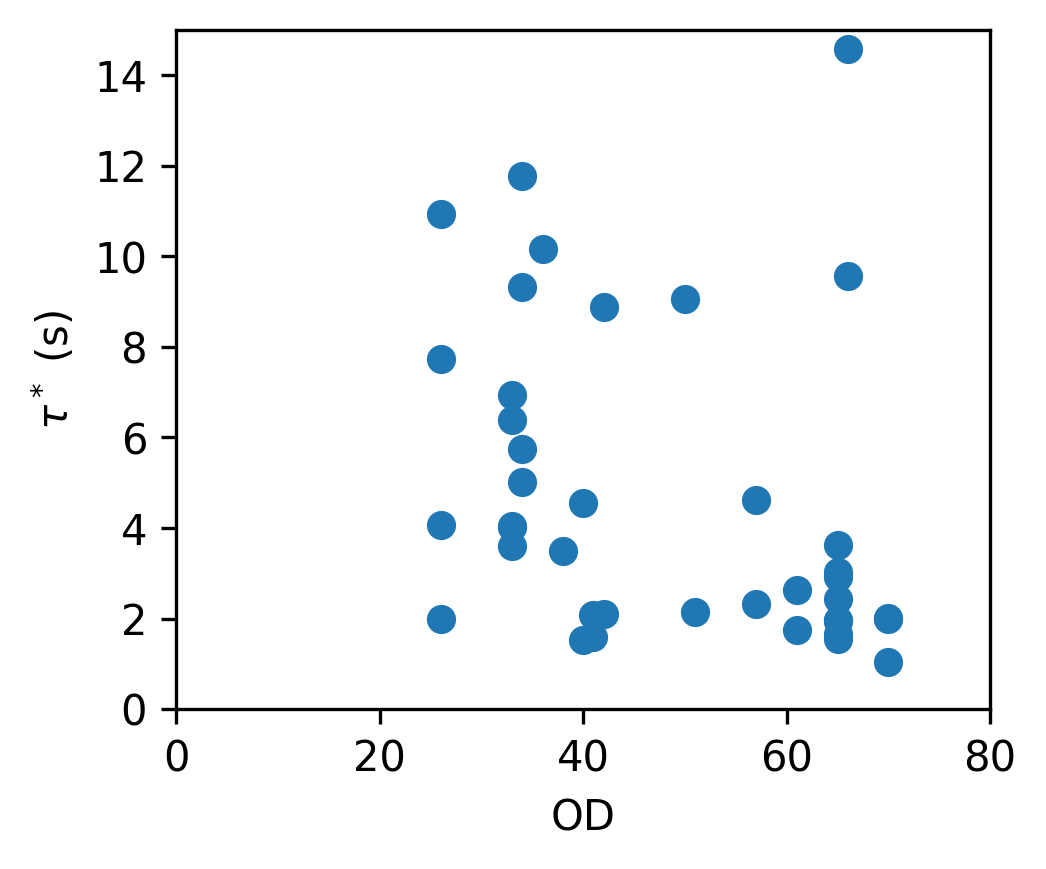

In [480]:
fig, ax = plt.subplots(figsize=(3.5, 3),dpi=300)
ax.scatter(log1.OD, log1.t2_fit)
ax.set_xlabel("OD")
ax.set_ylabel("$\\tau^*$ (s)")
ax.set_xlim([0, 80])
ax.set_ylim([0, 15])

The $\tau^*$ result above shows good linear dependence on $(D-d)/d^2$. This has inspired us to use theoretical $\tau^*$ as a given constant and fit for $\tau$ and $D_A$. <font color="blue">To be done</font>

## Appendix

### A. Small displacement approximation validation

The spring model assumes that the displacement of inner droplet is small compared to the outer droplet size, so that the restoring force is approximately proportional to the displacement in $y$. As we have estimated before, when the displacement goes beyond $r/2$ from equilibrium position, this approximation gets inaccurate. In practice, we want all the trajectory we analyze stay mostly in this range. Therefore, we compute the standard deviation y-displacement $\sigma_y$, and set a criterion $3\sigma_y < (R-r)$ to determine if we use the data in further analysis.

Here, I compute the standard deviation of $y$-position $\sigma_y$ and compute the critical number $c$ as

$$
c = \frac{3\sigma_y}{D-d}
$$

If $c > 0.5$, the trajectory is beyond the scope of the spring model. Otherwise, the spring model is expected to work.

In [263]:
data_folder = r"..\Data"
log = pd.read_excel(io=os.path.join(data_folder, "structured_log_DE.ods"))
c_list = []
for num, i in log.iterrows():
    traj = pd.read_csv(os.path.join(data_folder, "traj", "{:02d}.csv".format(i["DE#"])))
    c = 3 * traj.y.std() * i.MPP / (i.D - i.d) 
    c_list.append(c)

In [75]:
log1 = log.assign(c=c_list)

In [76]:
log1.to_csv("tmpc.csv")

### B. Influence of mean velocity

In [265]:
log1 = log.dropna(subset=["mean velocity (1s)"])

In [42]:
log1 = log1.drop(labels=133)

Text(0, 0.5, 'mean velocity ($\\mu$m/s)')

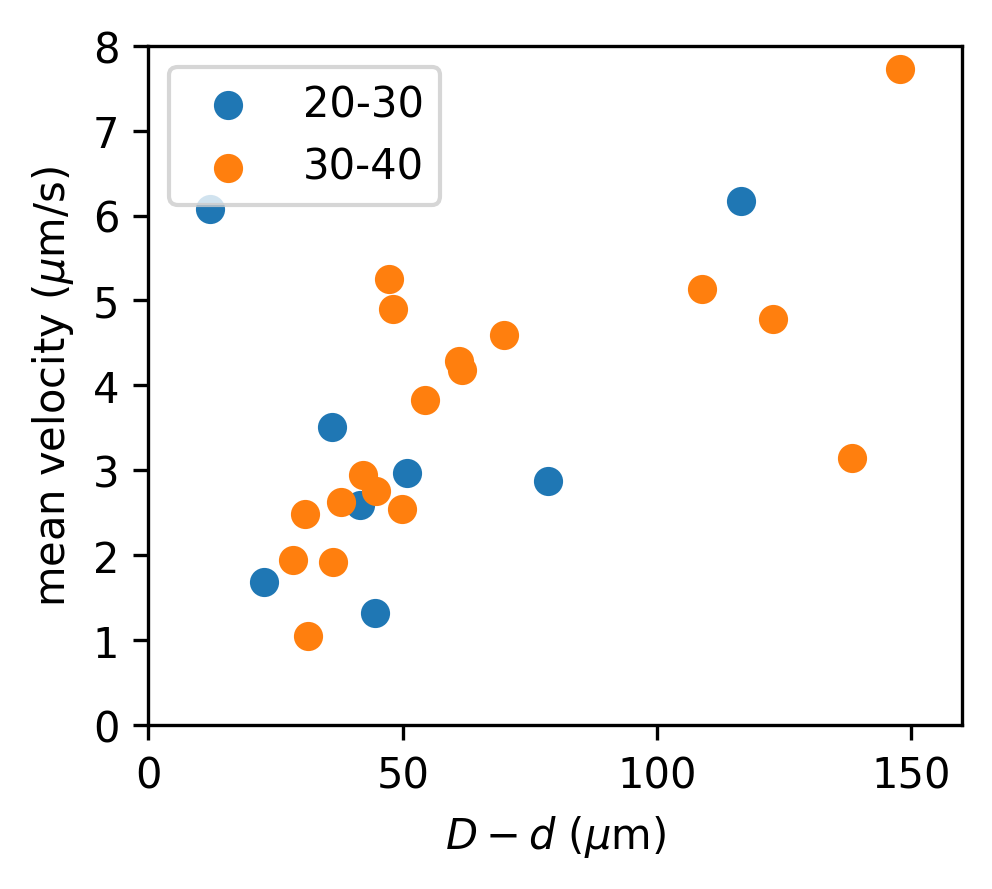

In [269]:
plt.figure(figsize=(3.5, 3), dpi=300)
log2 = log1.loc[log1.OD <= 30]
log3 = log1.loc[log1.OD > 30]
plt.scatter(log2["D-d"], log2["mean velocity (1s)"], label="20-30")
plt.scatter(log3["D-d"], log3["mean velocity (1s)"], label="30-40")
plt.legend()
plt.xlim([0, 160])
plt.ylim([0, 8])
plt.xlabel("$D-d$ ($\mu$m)")
plt.ylabel("mean velocity ($\mu$m/s)")

<font color="blue"> The mean velocity data suggests the activity of bacterial suspensions show dependence on the geometry, in particular the free space. However, it's worth noting that the mean velocity is measured by PIV on the whole droplet, including the region of inner droplet. As a result, it does not always faithfully quantify the bacterial activity. In some cases, when inner droplet occupies the majority of the outer droplet, PIV does not make any sense. The low activity of small free space also suggest the possibility that the real underlying control parameter is the total number of bacteria in the droplet. In a typical experiment for example, we have OD=30, corresponding to 2.4e10 cells/ml. In the case where $D=50, d=25$, the total number of bacteria is 1374. This is already small enough that we can hardly expect collective effect from. </font>

In [270]:
D = 50
d = 25
v = 4/3 * np.pi * ((D/2)**3-(d/2)**3) * 1e-12 # ml
number_concentration = 30 * 8e8
nc = v * number_concentration
print("Number of bacteria: {:d}".format(int(nc)))

Number of bacteria: 1374


### C. Total number of bacteria in a droplet

From the calculation above, we notice that in a typical double emulsion, the number of bacteria is not enormous. This leads to a question, do we need certain number of bacteria to constitute strong enough agitation that can make inner droplets fluctuate. To test that, we add an additional column to the structured data, "number of bacteria", and see if it is correlated with $\tau$, $\tau^*$ or $D_A$. 

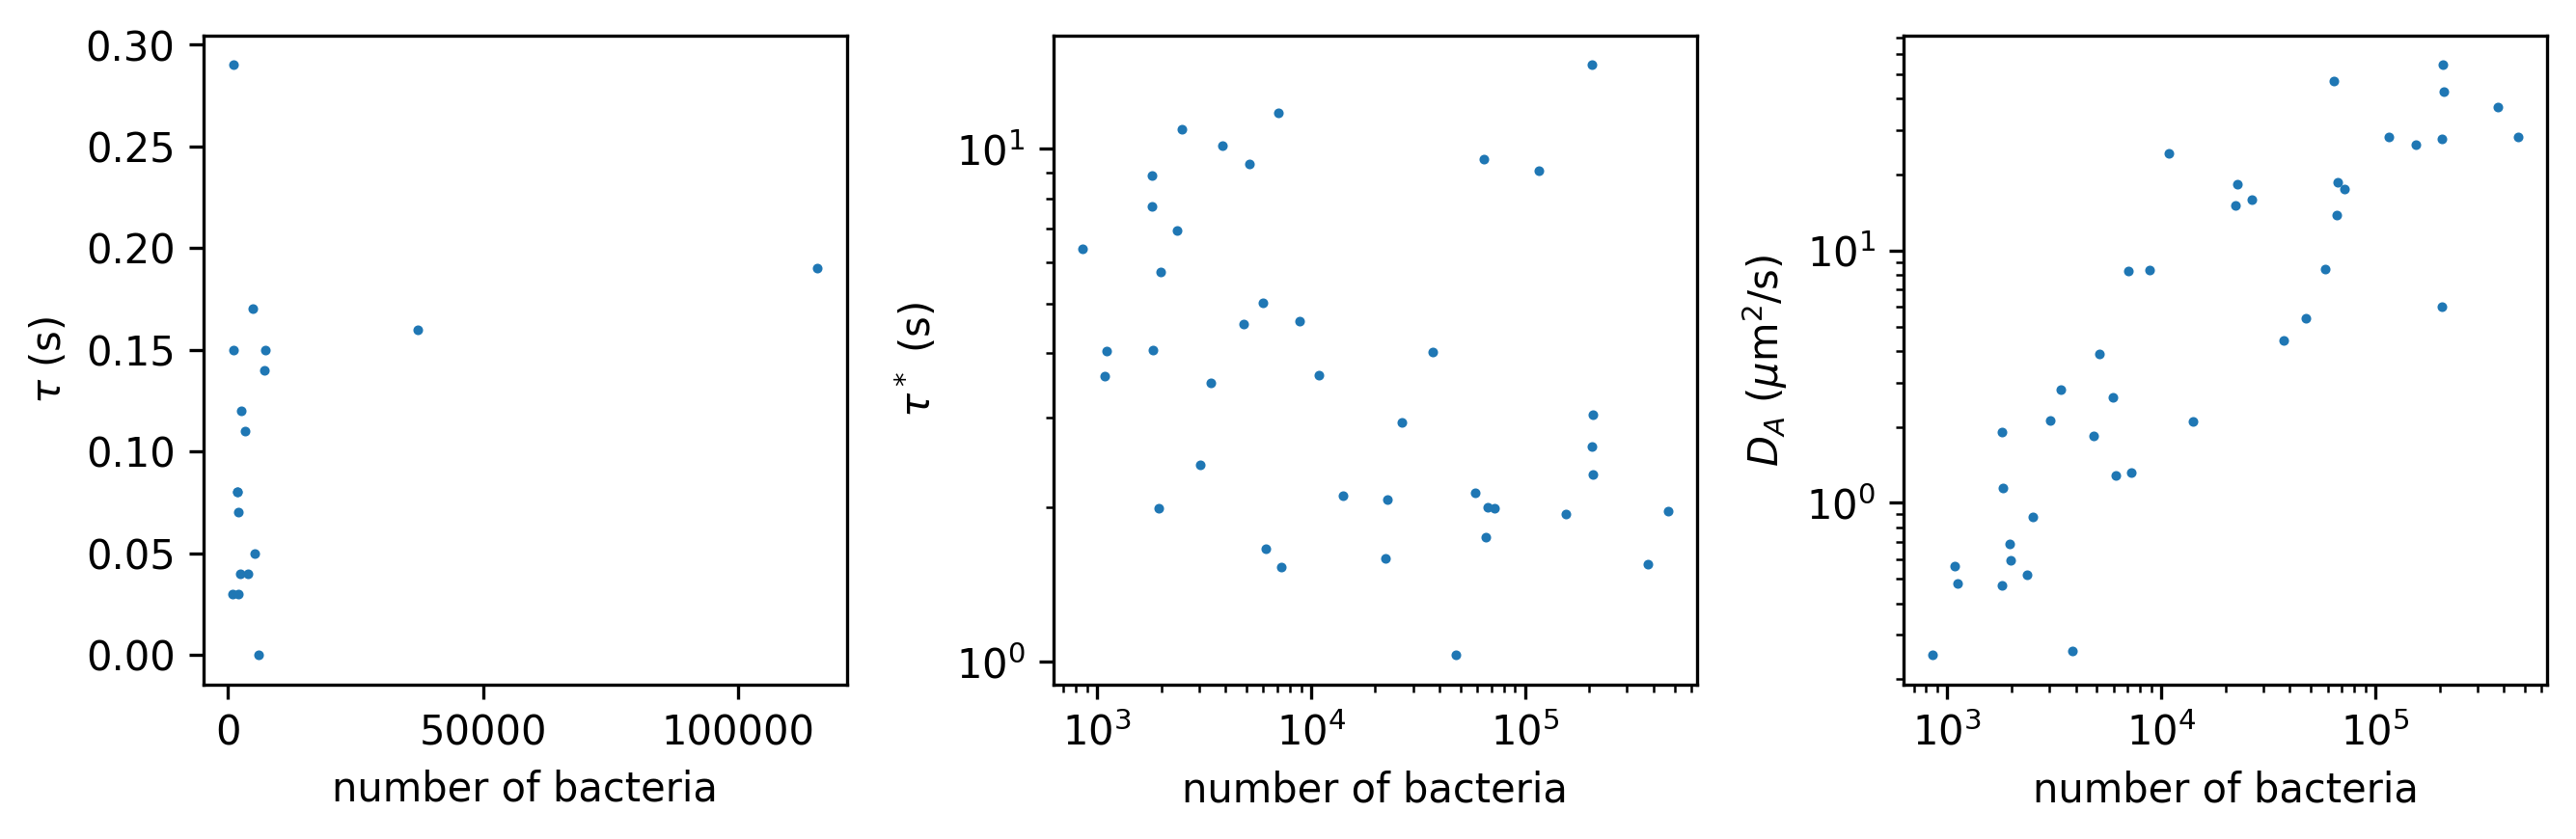

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
ax[0].scatter(log1["number of bacteria"], log1["t1_fit"], s=2)
ax[0].set_xlabel("number of bacteria")
ax[0].set_ylabel("$\\tau$ (s)")
# ax[0].loglog()
ax[1].scatter(log1["number of bacteria"], log1["t2_fit"], s=2)
ax[1].set_xlabel("number of bacteria")
ax[1].set_ylabel("$\\tau^*$ (s)")
ax[1].loglog()
ax[2].scatter(log1["number of bacteria"], log1["DA_fit"], s=2)
ax[2].set_xlabel("number of bacteria")
ax[2].set_ylabel("$D_A$ ($\mu$m$^2$/s)")
ax[2].loglog()

plt.tight_layout()

A few interesting things to note.

1. There is one obvious outlier in the first plot where $\tau = 0.56$ s. This is from DE#171, where $OD=40, D=184.76, d=37.01$. We look at the fitting of the MSD.

![fitting](../images/2022/07/171-fitting.png)

![correction](../images/2022/07/171-correction.png)

Nothing seems too strange up to here. In the video, I notice that besides the largest droplet, there are quite a few smaller droplets moving around the top of the dome and intereracting with the large droplet. This is probably the reason why the behavior of this particular droplet is abnormal. Deeper reason is still not clear.

![171 video](../images/2022/07/large-tau.gif)

2. $\tau^*$ is totally uncorrelated with number of bacteria.
3. $D_A$ shows a nice monotonic increasing trend with number of bacteria.

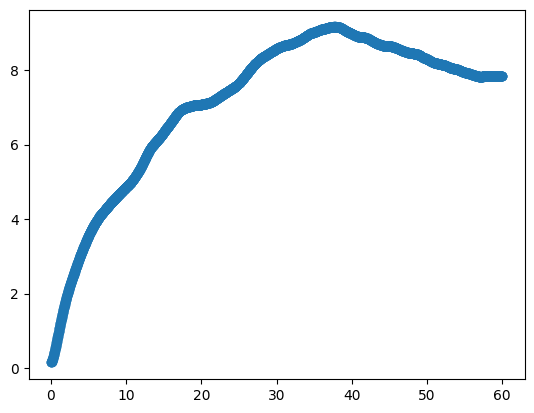

In [58]:
folder = r"../Data/traj/"
n = 193
traj = pd.read_csv(os.path.join(folder, "{:02d}.csv".format(n))).fillna(method="ffill")
fps = log.loc[n].FPS
mpp = log.loc[n].MPP
msd = tp.msd(traj, fps=fps, mpp=mpp, max_lagtime=3000)
plt.scatter(msd.lagt, msd["<y^2>"])



In [53]:
traj

,frame,x,y,particle
0,0,199.279304,126.565442,0
1,1,199.432184,126.127788,0
2,2,200.468721,125.119486,0
3,3,199.715274,126.399540,0
4,4,199.728671,126.974334,0
...,...,...,...,...
29995,29995,199.687421,122.006786,0
29996,29996,199.609380,121.659919,0
29997,29997,199.920968,122.586266,0
29998,29998,199.778343,121.586158,0


## 6 Play around with the data

### 6.1 Bound $r_o$ in bins

In [75]:
data = pd.read_csv(r"../Data/data_from_cristian_0923.csv")

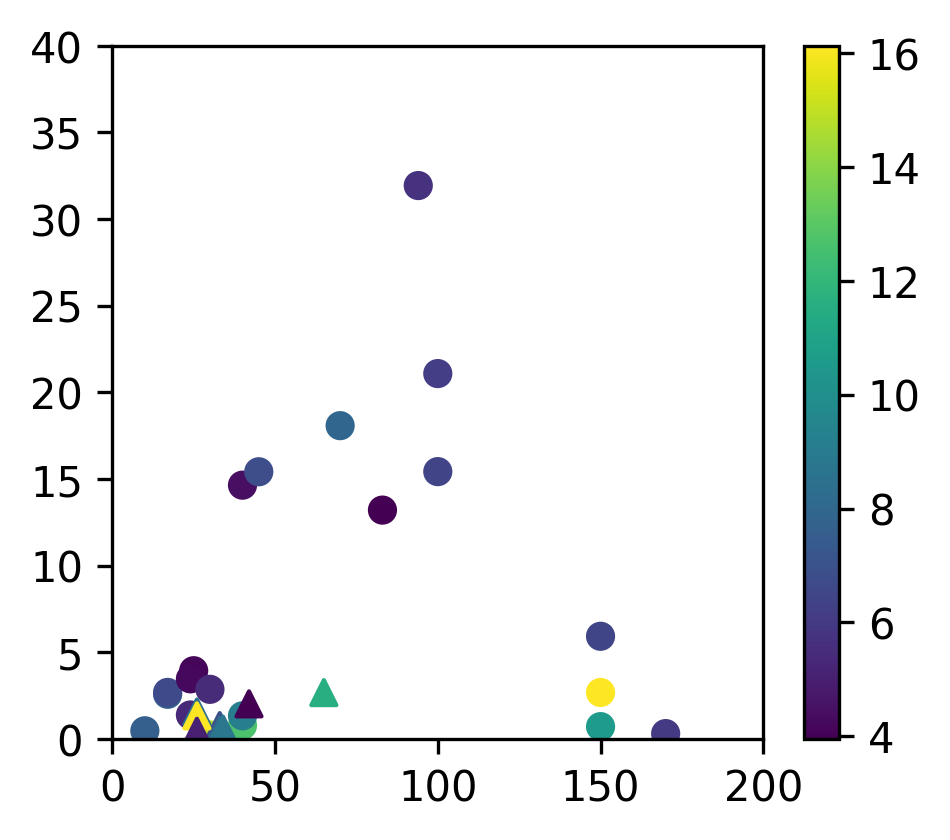

In [103]:
# set ro bounds 
ro_bounds = [20, 30]
data1 = data.loc[(data.ro>ro_bounds[0])&(data.ro<ro_bounds[1])]
# seperate Paris and Chile data in
data2 = data1.loc[data1.who==0]
data3 = data1.loc[data1.who==1]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.5, 3), dpi=300)

norm = colors.Normalize(vmin=data1.ri.min(), vmax=data1.ri.max())
sm = cm.ScalarMappable(norm, cmap="viridis")

ax.scatter(data2.OD, data2.DA, c=data2.ri, cmap="viridis", marker="o")
ax.scatter(data3.OD, data3.DA, c=data3.ri, cmap="viridis", marker="^")
ax.set_xlim([0, 200])
ax.set_ylim([0, 40])

plt.colorbar(sm, ax=ax)

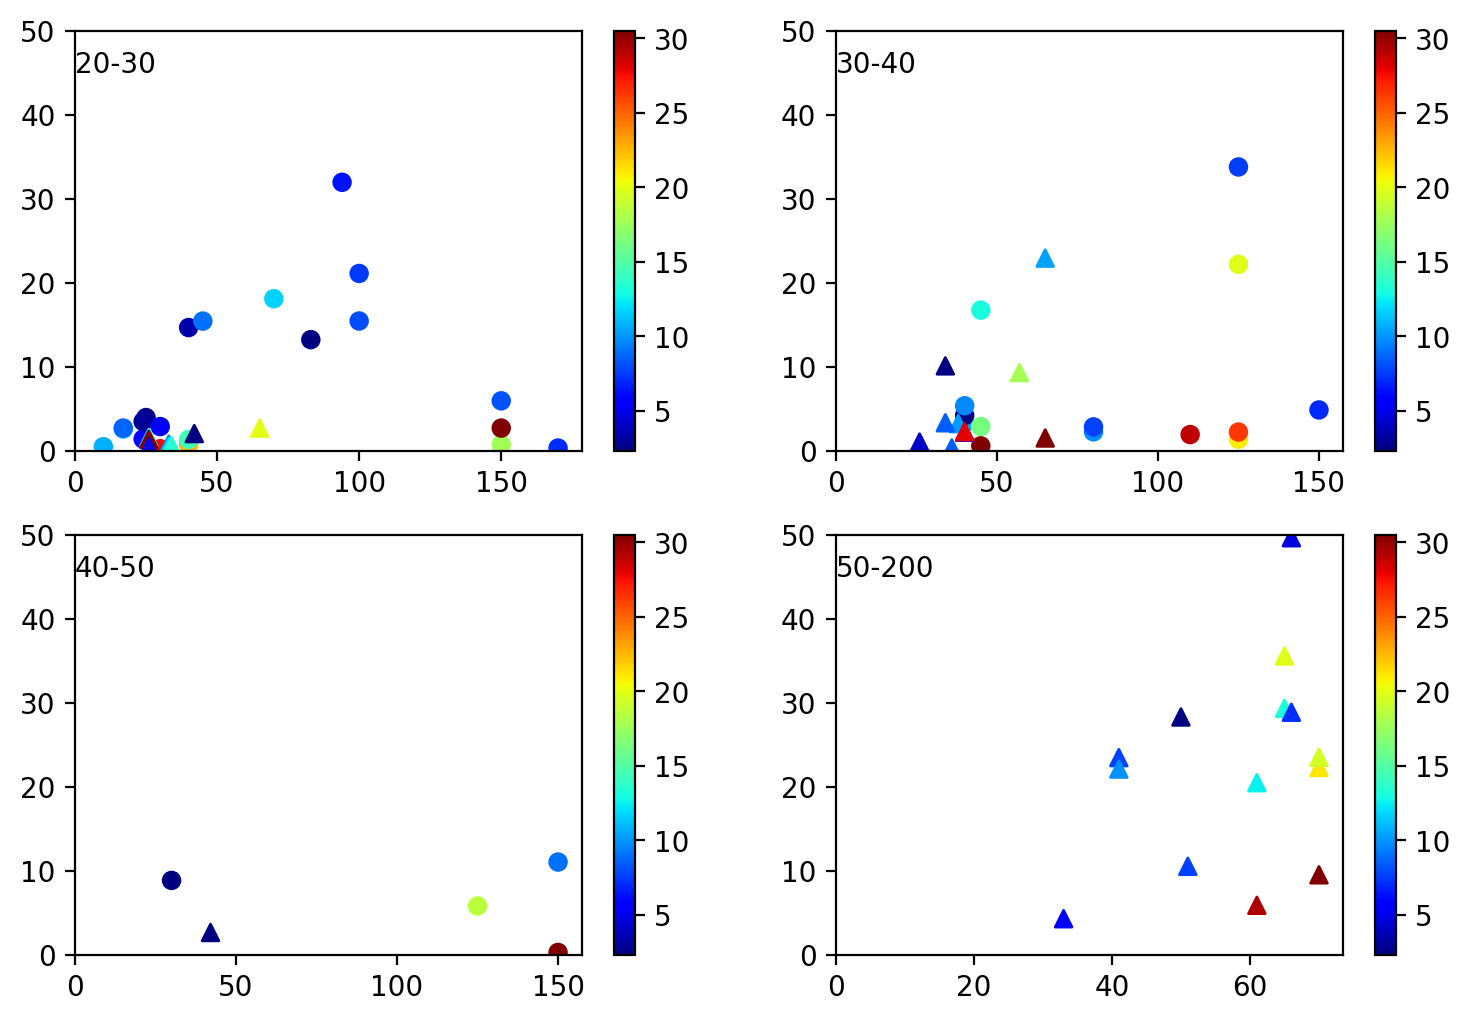

In [125]:
bstarts = range(20, 60, 10)
binsize = 10
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ri.min(), vmax=data.ri.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    if start == 50:
        end = 200
    data1 = data.loc[(data.ro>start)&(data.ro<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 2, count)
    count += 1
    
    ax.scatter(data2.OD, data2.DA, c=data2.ri, cmap="jet", marker="o")
    ax.scatter(data3.OD, data3.DA, c=data3.ri, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.OD.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.OD.max()*1.05])
    ax.set_ylim([0, 50])
    plt.colorbar(sm, ax=ax)

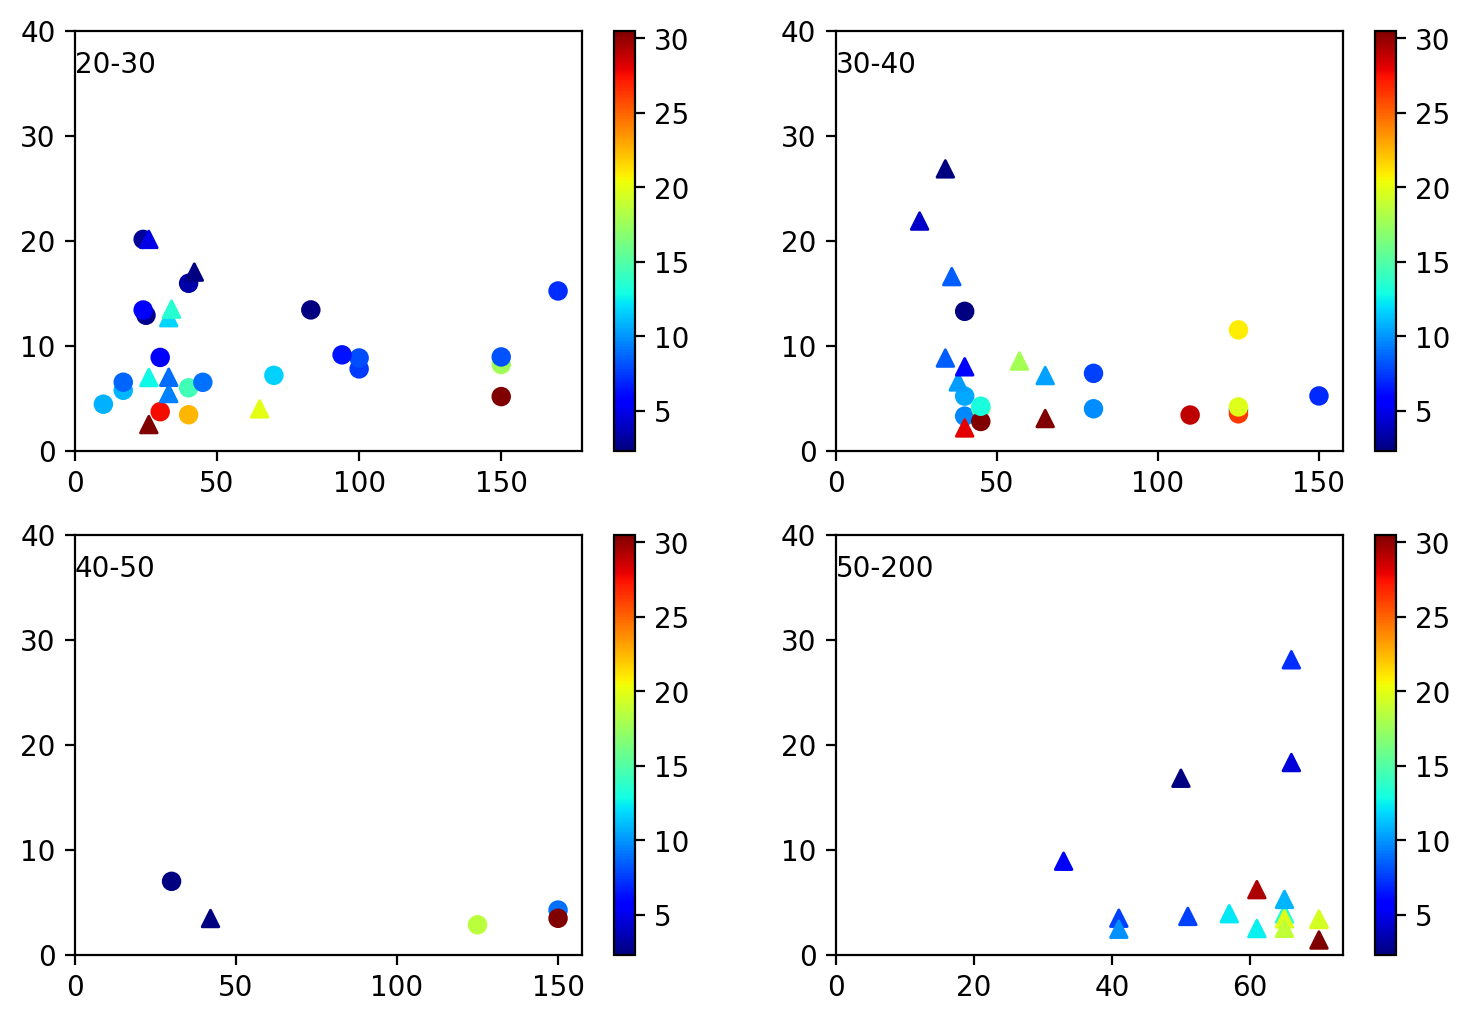

In [124]:
bstarts = range(20, 60, 10)
binsize = 10
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ri.min(), vmax=data.ri.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    if start == 50:
        end = 200
    data1 = data.loc[(data.ro>start)&(data.ro<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 2, count)
    count += 1
    
    ax.scatter(data2.OD, data2.t2, c=data2.ri, cmap="jet", marker="o")
    ax.scatter(data3.OD, data3.t2, c=data3.ri, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.OD.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.OD.max()*1.05])
    ax.set_ylim([0, 40])
    plt.colorbar(sm, ax=ax)

### 6.2 Bin $r_i$

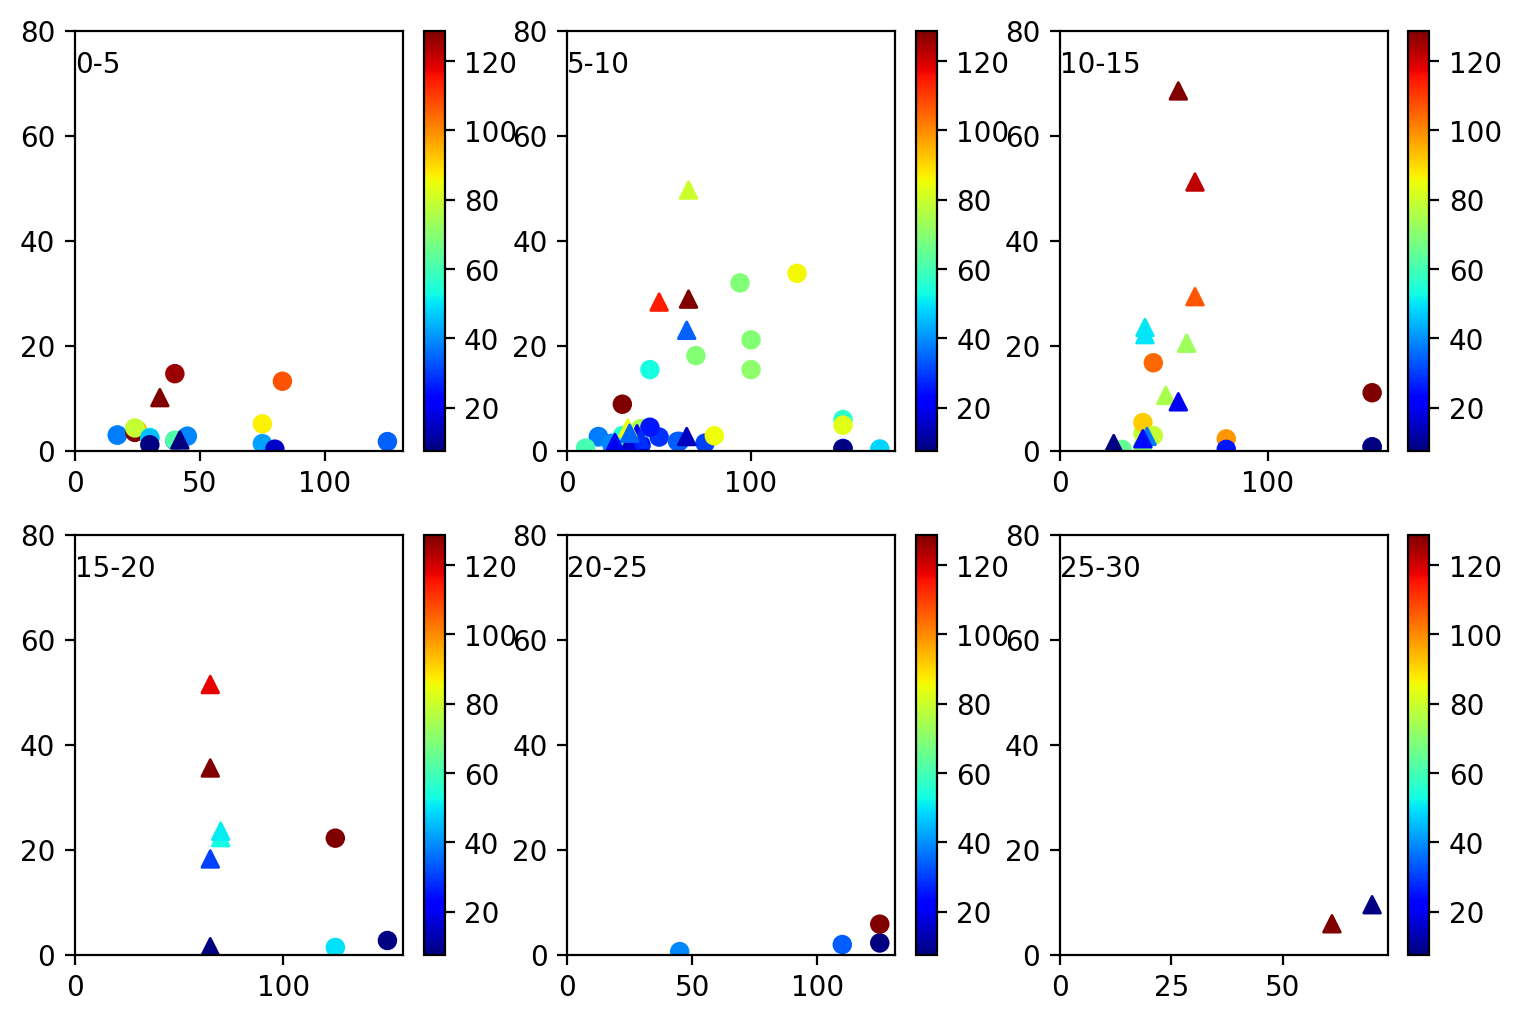

In [132]:
bstarts = range(0, 30, 5)
binsize = 5
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ro.min(), vmax=data.ro.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    data1 = data.loc[(data.ri>=start)&(data.ri<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 3, count)
    count += 1
    
    ax.scatter(data2.OD, data2.DA, c=data2.ro, cmap="jet", marker="o")
    ax.scatter(data3.OD, data3.DA, c=data3.ro, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.OD.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.OD.max()*1.05])
    ax.set_ylim([0, 80])
    plt.colorbar(sm, ax=ax)

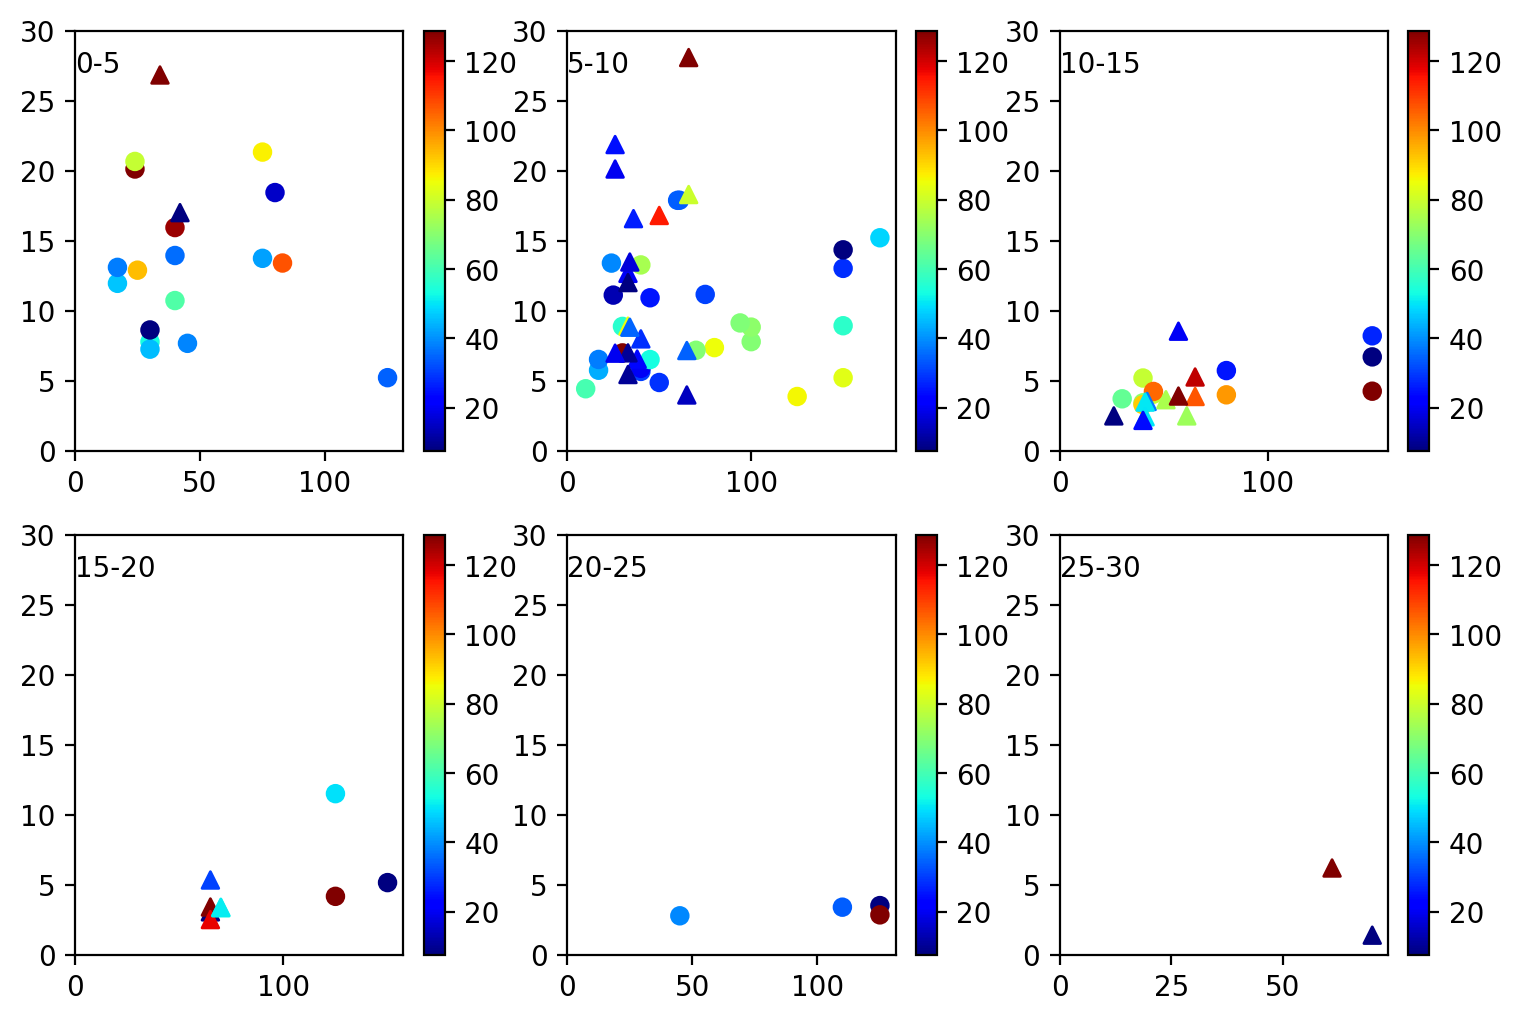

In [133]:
bstarts = range(0, 30, 5)
binsize = 5
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ro.min(), vmax=data.ro.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    data1 = data.loc[(data.ri>=start)&(data.ri<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 3, count)
    count += 1
    
    ax.scatter(data2.OD, data2.t2, c=data2.ro, cmap="jet", marker="o")
    ax.scatter(data3.OD, data3.t2, c=data3.ro, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.OD.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.OD.max()*1.05])
    ax.set_ylim([0, 30])
    plt.colorbar(sm, ax=ax)

### 6.3 Bin OD

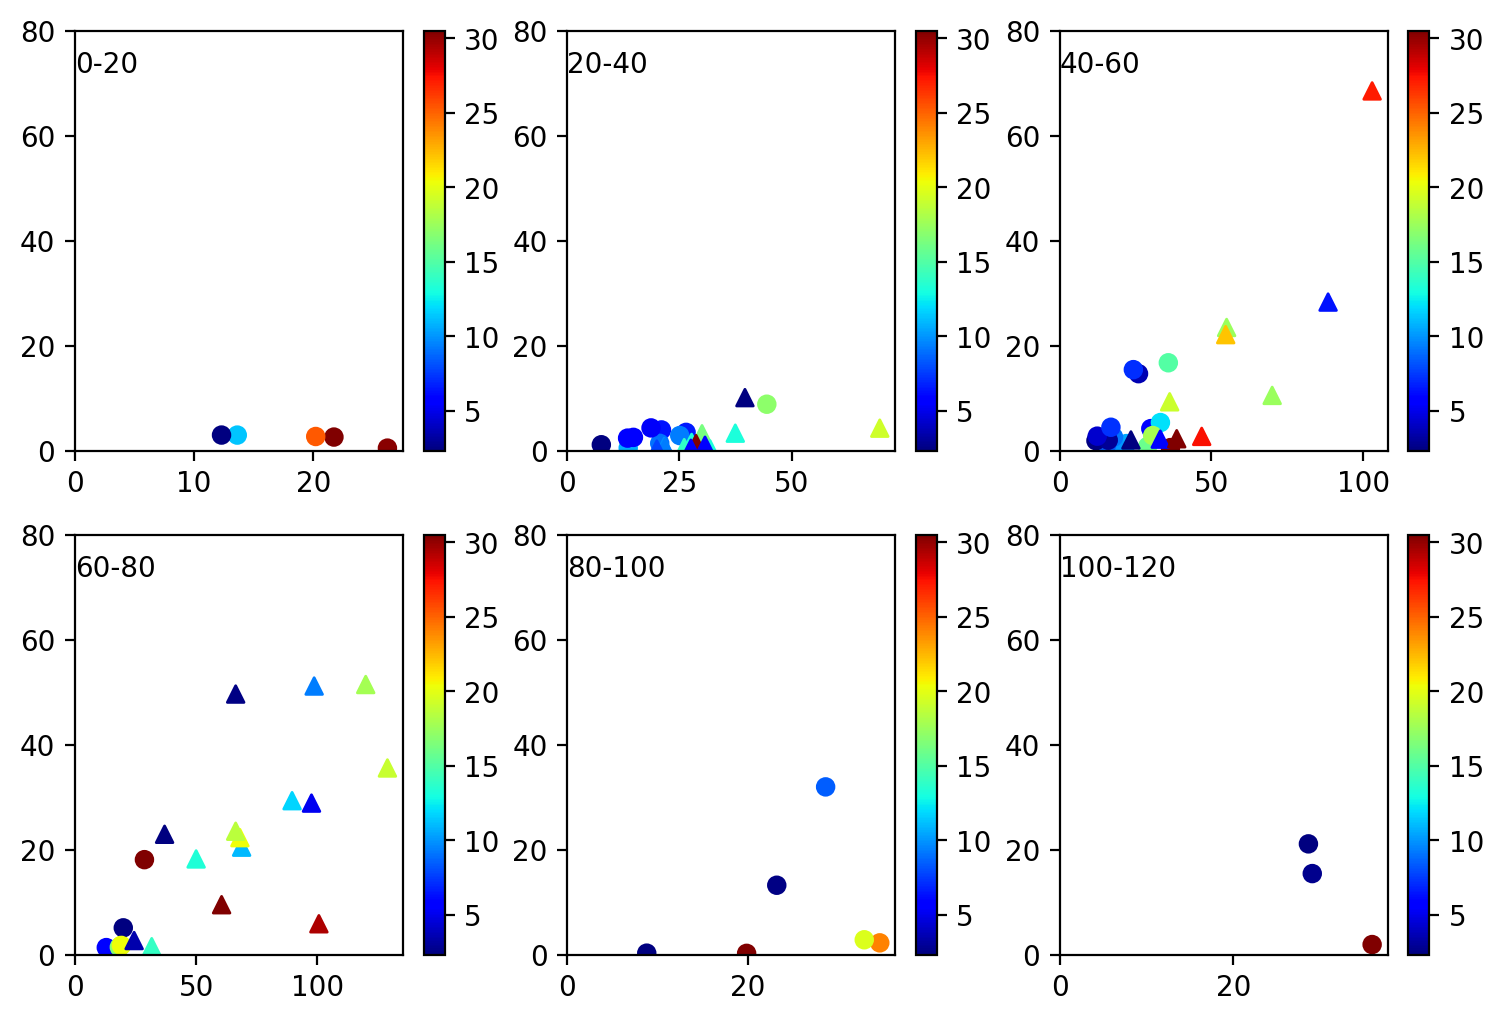

In [134]:
bstarts = range(0, 120, 20)
binsize = 20
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ri.min(), vmax=data.ri.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    data1 = data.loc[(data.OD>=start)&(data.OD<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 3, count)
    count += 1
    
    ax.scatter(data2.ro, data2.DA, c=data2.ri, cmap="jet", marker="o")
    ax.scatter(data3.ro, data3.DA, c=data3.ri, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.ro.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.ro.max()*1.05])
    ax.set_ylim([0, 80])
    plt.colorbar(sm, ax=ax)

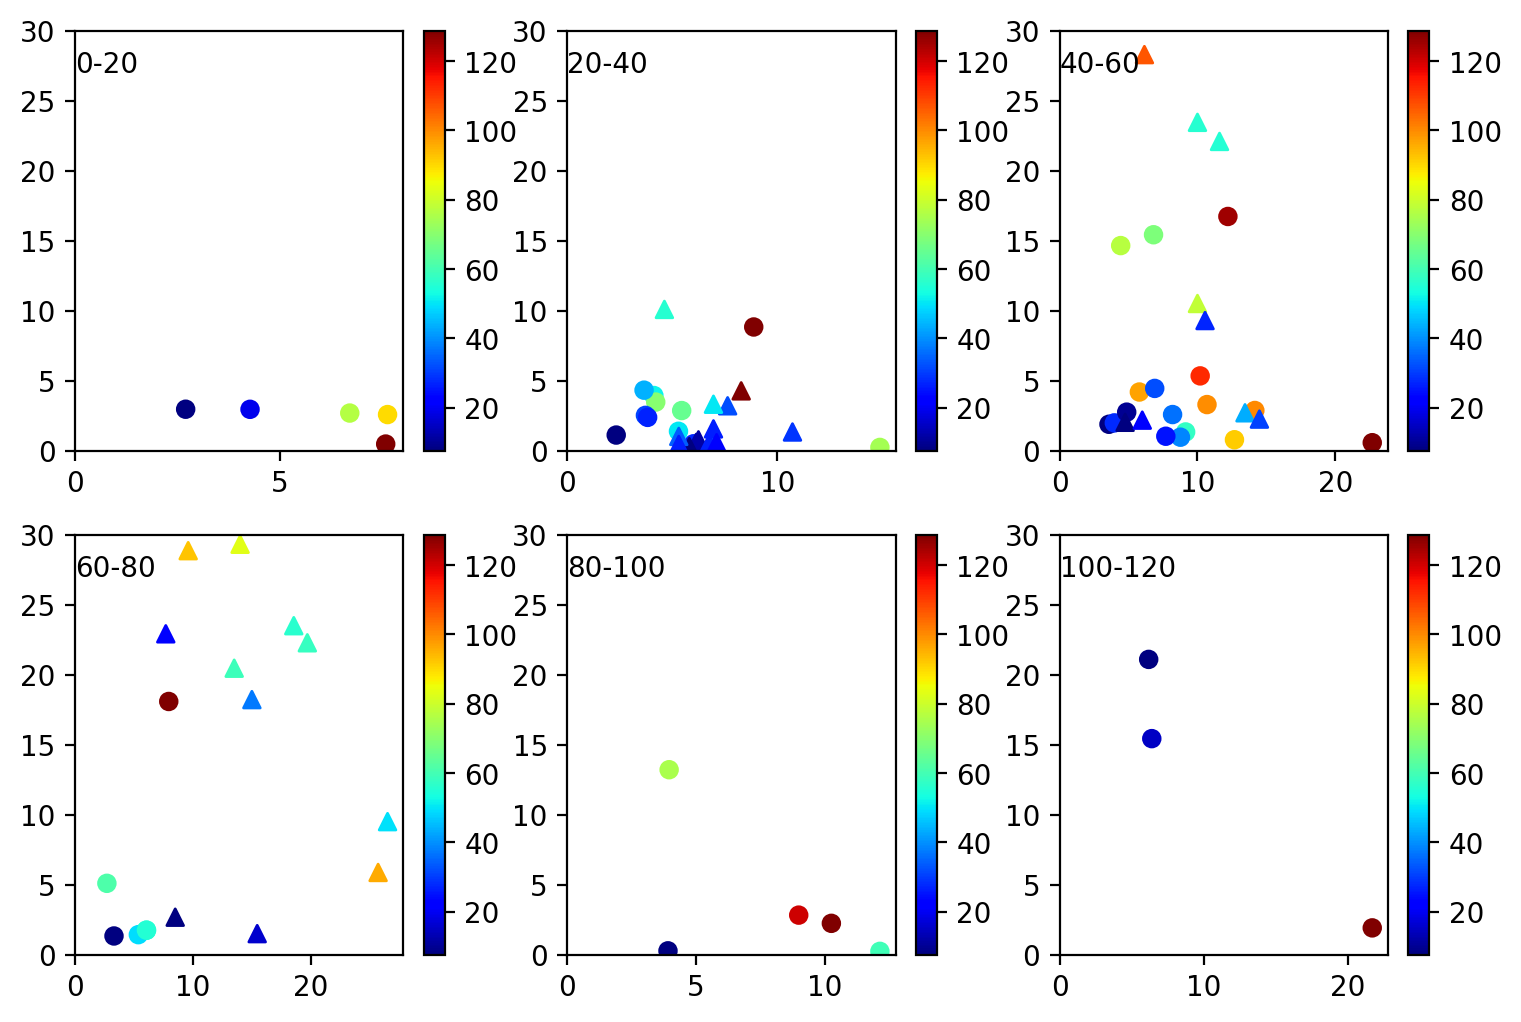

In [140]:
bstarts = range(0, 120, 20)
binsize = 20
cmap = "jet"
fig = plt.figure(figsize=(9, 6), dpi=200)

norm = colors.Normalize(vmin=data.ro.min(), vmax=data.ro.max())
sm = cm.ScalarMappable(norm, cmap="jet")

count = 1
for start in bstarts:
    end = start + binsize
    data1 = data.loc[(data.OD>=start)&(data.OD<end)]
    data2 = data1.loc[data1.who==0]
    data3 = data1.loc[data1.who==1]
    ax = fig.add_subplot(2, 3, count)
    count += 1
    
    ax.scatter(data2.ri, data2.DA, c=data2.ro, cmap="jet", marker="o")
    ax.scatter(data3.ri, data3.DA, c=data3.ro, cmap="jet", marker="^")
    ax.annotate("{0:d}-{1:d}".format(start, end), [0, 0.9], xycoords="axes fraction")
    if np.isnan(data1.ri.max()):
        ax.set_xlim([0, 100])
    else:
        ax.set_xlim([0, data1.ri.max()*1.05])
    ax.set_ylim([0, 30])
    plt.colorbar(sm, ax=ax)

[]

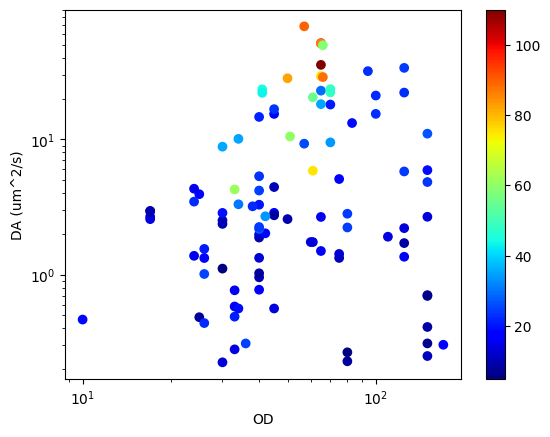

In [150]:
norm = colors.Normalize(vmin=(data.ro-data.ri).min(), vmax=(data.ro-data.ri).max())
sm = cm.ScalarMappable(norm, cmap="jet")
fig, ax = plt.subplots()

ax.scatter(data.OD, data.DA, c=data.ro-data.ri, cmap="jet")
# ax.set_xlim([0, 200])
# ax.set_ylim([0, 79])
plt.colorbar(sm, ax=ax)
ax.set_xlabel("OD")
ax.set_ylabel("DA (um^2/s)")
ax.loglog()

Text(0, 0.5, 'DA (um^2/s)')

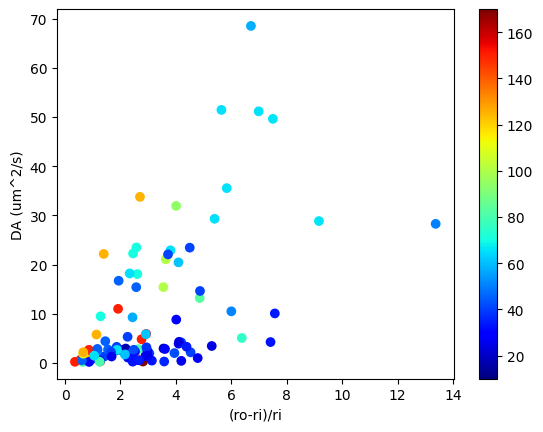

In [154]:
norm = colors.Normalize(vmin=data.OD.min(), vmax=data.OD.max())
sm = cm.ScalarMappable(norm, cmap="jet")
fig, ax = plt.subplots()

ax.scatter((data.ro-data.ri)/data.ri, data.DA, c=data.OD, cmap="jet")
# ax.set_xlim([0, 200])
# ax.set_ylim([0, 79])
plt.colorbar(sm, ax=ax)
ax.set_xlabel("(ro-ri)/ri")
ax.set_ylabel("DA (um^2/s)")
# ax.loglog()

Text(0, 0.5, 'DA (um^2/s)')

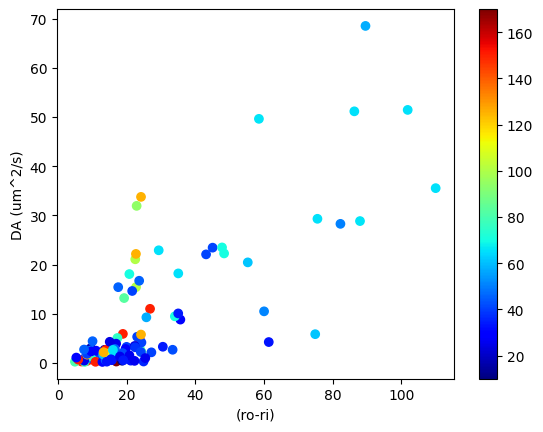

In [156]:
norm = colors.Normalize(vmin=data.OD.min(), vmax=data.OD.max())
sm = cm.ScalarMappable(norm, cmap="jet")
fig, ax = plt.subplots()

ax.scatter(data.ro-data.ri, data.DA, c=data.OD, cmap="jet")
# ax.set_xlim([0, 200])
# ax.set_ylim([0, 79])
plt.colorbar(sm, ax=ax)
ax.set_xlabel("(ro-ri)")
ax.set_ylabel("DA (um^2/s)")
# ax.loglog()

### Collapse?

Text(0, 0.5, 'DA * (ro+ri) / (ro-ri)')

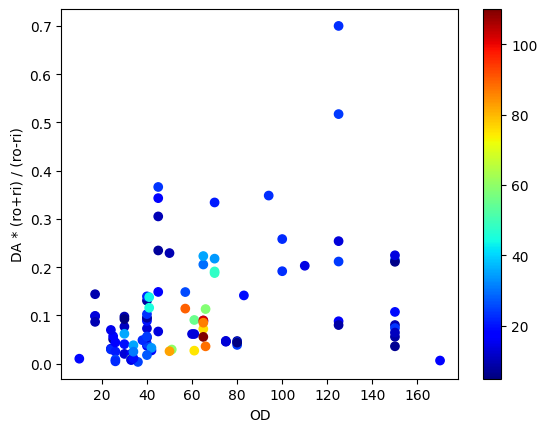

In [189]:
norm = colors.Normalize(vmin=(data.ro-data.ri).min(), vmax=(data.ro-data.ri).max())
sm = cm.ScalarMappable(norm, cmap="jet")
fig, ax = plt.subplots()

f = data.ri/(data.ro-data.ri)**2
ax.scatter(data.OD, data.DA*f**1, c=data.ro-data.ri, cmap="jet")
# ax.set_xlim([0, 100])
# ax.set_ylim([0, 79])
plt.colorbar(sm, ax=ax)
ax.set_xlabel("OD")
ax.set_ylabel("DA * (ro+ri) / (ro-ri)")